In [1]:
from typing import Union, Tuple, Optional

import pandas as pd
import segyio
import numpy as np
import pylab as plt
import lasio
import os

from scipy import signal
import scipy.sparse.linalg 
from scipy.interpolate import CubicSpline, interp1d
from scipy.fft import fft, fftshift, fftfreq
from scipy.ndimage import gaussian_filter
from scipy.signal import hilbert, butter, tukey, filtfilt, coherence

import cmath
from math import sqrt, pi, ceil
from seiscm import seismic

from tqdm import tqdm

In [2]:
def segy_file(filename):
    file = segyio.open(filename, ignore_geometry = True) # открываем файл
    tr = []
    cord_x = []
    cord_y = []

    for i in range(file.tracecount):
        tr.append(file.trace[i]) # достаем значения на приемниках и записываем в список
        cord_x.append(file.header[i][segyio.TraceField.SourceX]) # координаты источника по Х для выбранного приемника 
        cord_y.append(file.header[i][segyio.TraceField.SourceY]) # координаты источника по Y для выбранного приемника 
        
    tr = np.stack(tr) # преобразуем список в массив, где каждая строка отвечает приемнику, а столбцы - значение в момент t
    df = pd.DataFrame({'CDP_X' :cord_x, 'CDP_Y' :cord_y}) # создаем таблицу с координатами источников и приемникав и дистанцией между ними
    return df, tr

def write_SEGY(new_traces, df ,name, dt):
    spec = segyio.spec()
    spec.sorting = 5
    spec.format = 5
    spec.samples = list(np.arange(0,new_traces.shape[1]*dt,dt))
    spec.iline = 189
    spec.xline = 193
    spec.ilines = [df['INLINE'].values]
    #spec.xlines = [df['XLINE'].values]
    spec.tracecount = new_traces.shape[0]
    a = segyio.create(name,spec)
    for i in range(spec.tracecount):
        a.trace[i] = new_traces[i,:]
        a.header[i][segyio.TraceField.CDP_X] = np.int32(df['CDP_X'].values[0] + i)
        a.header[i][segyio.TraceField.CDP_Y] = np.int32(df['CDP_Y'].values[0]+ i)
        a.header[i][segyio.TraceField.CDP] = np.int32(df['CDP_Y'].values[0]+ i)
    #a.flush()
    return 0

    
def interpolate_parameters(param, df_well, column_name):
    """
    Function interpolates parameters from well to the same grid
    
    Parameters
    ----------
    Input:
        param - regular grid (time or depth)
        df_well - dataframe with well_date
        column_name - nonregular grid (HT0 or H)

    Output:
        RHOB_int - interpolate densities
        Vp_int - interpolate Vp
        Vs_int - interpolate Vs
        tmp - interpolate HT0 or H
    """
    if column_name == 'T':
        df_tmp = df_well.loc[:,['RHO','T']].dropna()
        RHOB_int=np.interp(param,df_tmp['T'],df_tmp['RHO'])

        df_tmp = df_well.loc[:,['Vp','T']].dropna()
        Vp_int=np.interp(param,df_tmp['T'],df_tmp['Vp'])

        df_tmp = df_well.loc[:,['Vs','T']].dropna()
        Vs_int=np.interp(param,df_tmp['T'],df_tmp['Vs'])

        df_tmp = df_well.loc[:,['H','T']].dropna()
        tmp = np.interp(param,df_tmp['T'],df_tmp['H'])
    elif column_name == 'H':
        df_tmp = df_well.loc[:,['RHO','H']].dropna()
        RHOB_int=np.interp(param,df_tmp['H'],df_tmp['RHO'])

        df_tmp = df_well.loc[:,['Vp','H']].dropna()
        Vp_int=np.interp(param,df_tmp['H'],df_tmp['Vp'])

        df_tmp = df_well.loc[:,['Vs','H']].dropna()
        Vs_int=np.interp(param,df_tmp['H'],df_tmp['Vs'])

        df_tmp = df_well.loc[:,['HT0','H']].dropna()
        tmp = np.interp(param,df_tmp['H'],df_tmp['HT0'])
    
    return RHOB_int, Vp_int, Vs_int, tmp


def reflection_coef(V, Rho):
    '''
    Функция расчета коэффициентов отражения

    Параметры
    -------------
    Вход:
        V - Массив скоростей
        Rho - Массив плотностей

    Выход:
        Rpp - Коэффициенты отражения
    '''

    Rpp = np.zeros((len(V)))

    for i in range(len(V) - 1):

        I1 = V[i] * Rho[i]
        I2 = V[i + 1] * Rho[i + 1]
        Rpp[i] = (I2 - I1) / (I2 + I1)
    

    ''' Дополнительно для последнего горизонта '''
    
    i += 1
    Rpp[i] = 0

    return Rpp

def kk_count(a0,b0): ##коэф. корреляции
    """
    Function calculation of the correlation coefficient between two signals
    
    Parameters
    ----------
    Input:
        a0 - array of signal #1
        b0 - array of signal #2

    Output:
        kk - correlation coefficient between two signals
    """
    kk = (np.mean(b0*a0)-np.mean(b0)*np.mean(a0))/((np.std(a0)*np.std(b0)))
    return kk

def kk_cut_T(trace, synt_trace, dt, T):
    '''
    Функция рассчета коэф. корреляции на отрезке T

    Параметры
    -------------
    Вход:
        trace - 1 сейсмотрасса (Реальная трасса) (np.)
        synt_trace - 2 сейсмотрасса (Синтетическая трасса)
        dt - Шаг по времении (дискретизация)
        T - Ограниченый вектор времен, для расчета корреляции

    Выход:
        kk_cut - Коэф. корреляции (float)
    '''

    index_min_value_kk = int(T[0] / dt); index_max_value_kk = ceil(T[-1] / dt)
    
    traces_cut_kk = trace[index_min_value_kk:index_max_value_kk]
    amp_cut_refl_kk = synt_trace[index_min_value_kk:index_max_value_kk]

    kk_cut = np.round(kk_count(traces_cut_kk/np.max(np.abs(traces_cut_kk)),amp_cut_refl_kk/np.max(np.abs(amp_cut_refl_kk))), 3)
    
    return kk_cut

def ifft_with_phase(F, x, phase):
    """
    Поворот фазы в частотной области и обратное преобразование Фурье
        
    Параметры
    ----------
    Исходные:
        F - фурье-спектр трассы
        x - ось частотной области
        phase - угол поворота в радианах
        
    Конечные:
        np.real(Finv) - трассировка во временной области со сдвигом фазы
    """
    sign = np.ones(len(x))
    sign[np.where(x < 0)] = -1 * sign[np.where(x < 0)]
    sign[np.where(x == 0)] = 0

    nprect = np.vectorize(cmath.rect)

    B_amp = np.abs(F)
    B_faz = np.angle(F) + sign * phase

    Data = nprect(B_amp, B_faz)

    Finv = np.real(np.asarray(np.fft.ifft(Data)))
    return Finv

def teor_sig_with_phases(imp, dt_well, phases, refl_int):
    """
    Расчет трасс со сдвигом фазы
    
    Параметры
    ----------
    Исходные:
        imp - данные класса импульса
        dt_well - шаг по времени (скважина)
        refl_int - отражательная способность 

    Конечные:
        Teor_sig_arr - матрица трасс со сдвигом фазы
    """
    DT = 1000
    F = np.fft.fft(imp)
    x = np.fft.fftfreq(len(imp), dt_well)
    Teor_sig = []
    Trace = []
    for ii in range(0, len(phases)):
        Wavelet = ifft_with_phase(F, x, phases[ii])
        Teor_sig.append(Wavelet)
        Trace.append(np.convolve(refl_int, Wavelet, mode='same'))
        
    Teor_sig_arr = np.stack(Teor_sig, axis=0)
    Trace_arr = np.stack(Trace, axis=0)
    return Teor_sig_arr, Trace_arr



### Считывание куба

In [3]:
filename3 = 'Data//XLine_436_TNG.sgy'
df3, trace3 = segy_file(filename3)


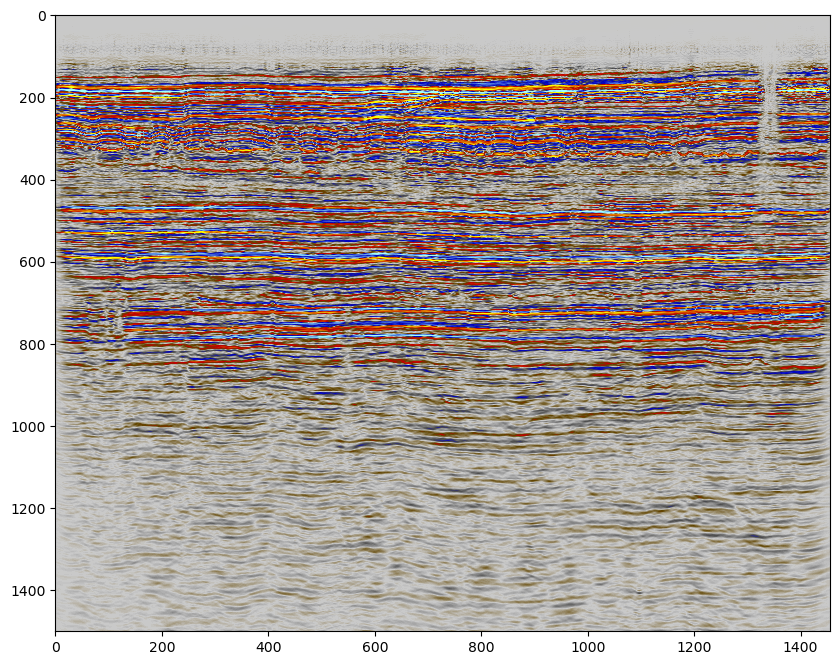

In [4]:
plt.figure(figsize = (10,8))
coef = 4
plt.imshow(trace3.T, aspect='auto',cmap = seismic(),
           vmin = np.mean(trace3) -coef*np.std(trace3),vmax = np.mean(trace3) +coef*np.std(trace3))


### Считывание скважинных данных

In [5]:
Vs_data = lasio.read('Data\\LAS\VS.las')
Vp_data = lasio.read('Data\\LAS\VP.las')
Rho_data = lasio.read('Data\\LAS\RHO.las')


C:\Users\User\AppData\Roaming\Python\Python39\site-packages\lasio\las.py:511: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  curve_arr[curve_arr == provisional_null] = np.nan


In [6]:

Vs = 1 / Vs_data.data.T[1] * 10e5
Vp = 1 / Vp_data.data.T[1] * 10e5
Vp_interp = np.interp(Vs_data.data.T[0], Vp_data.data.T[0], Vp)
Rho_interp = np.interp(Vs_data.data.T[0], Rho_data.data.T[0], Rho_data.data.T[1])

df = pd.DataFrame({'H':Vs_data.data.T[0],'Vp':Vp_interp,'Vs':Vs,'RHO':Rho_interp})


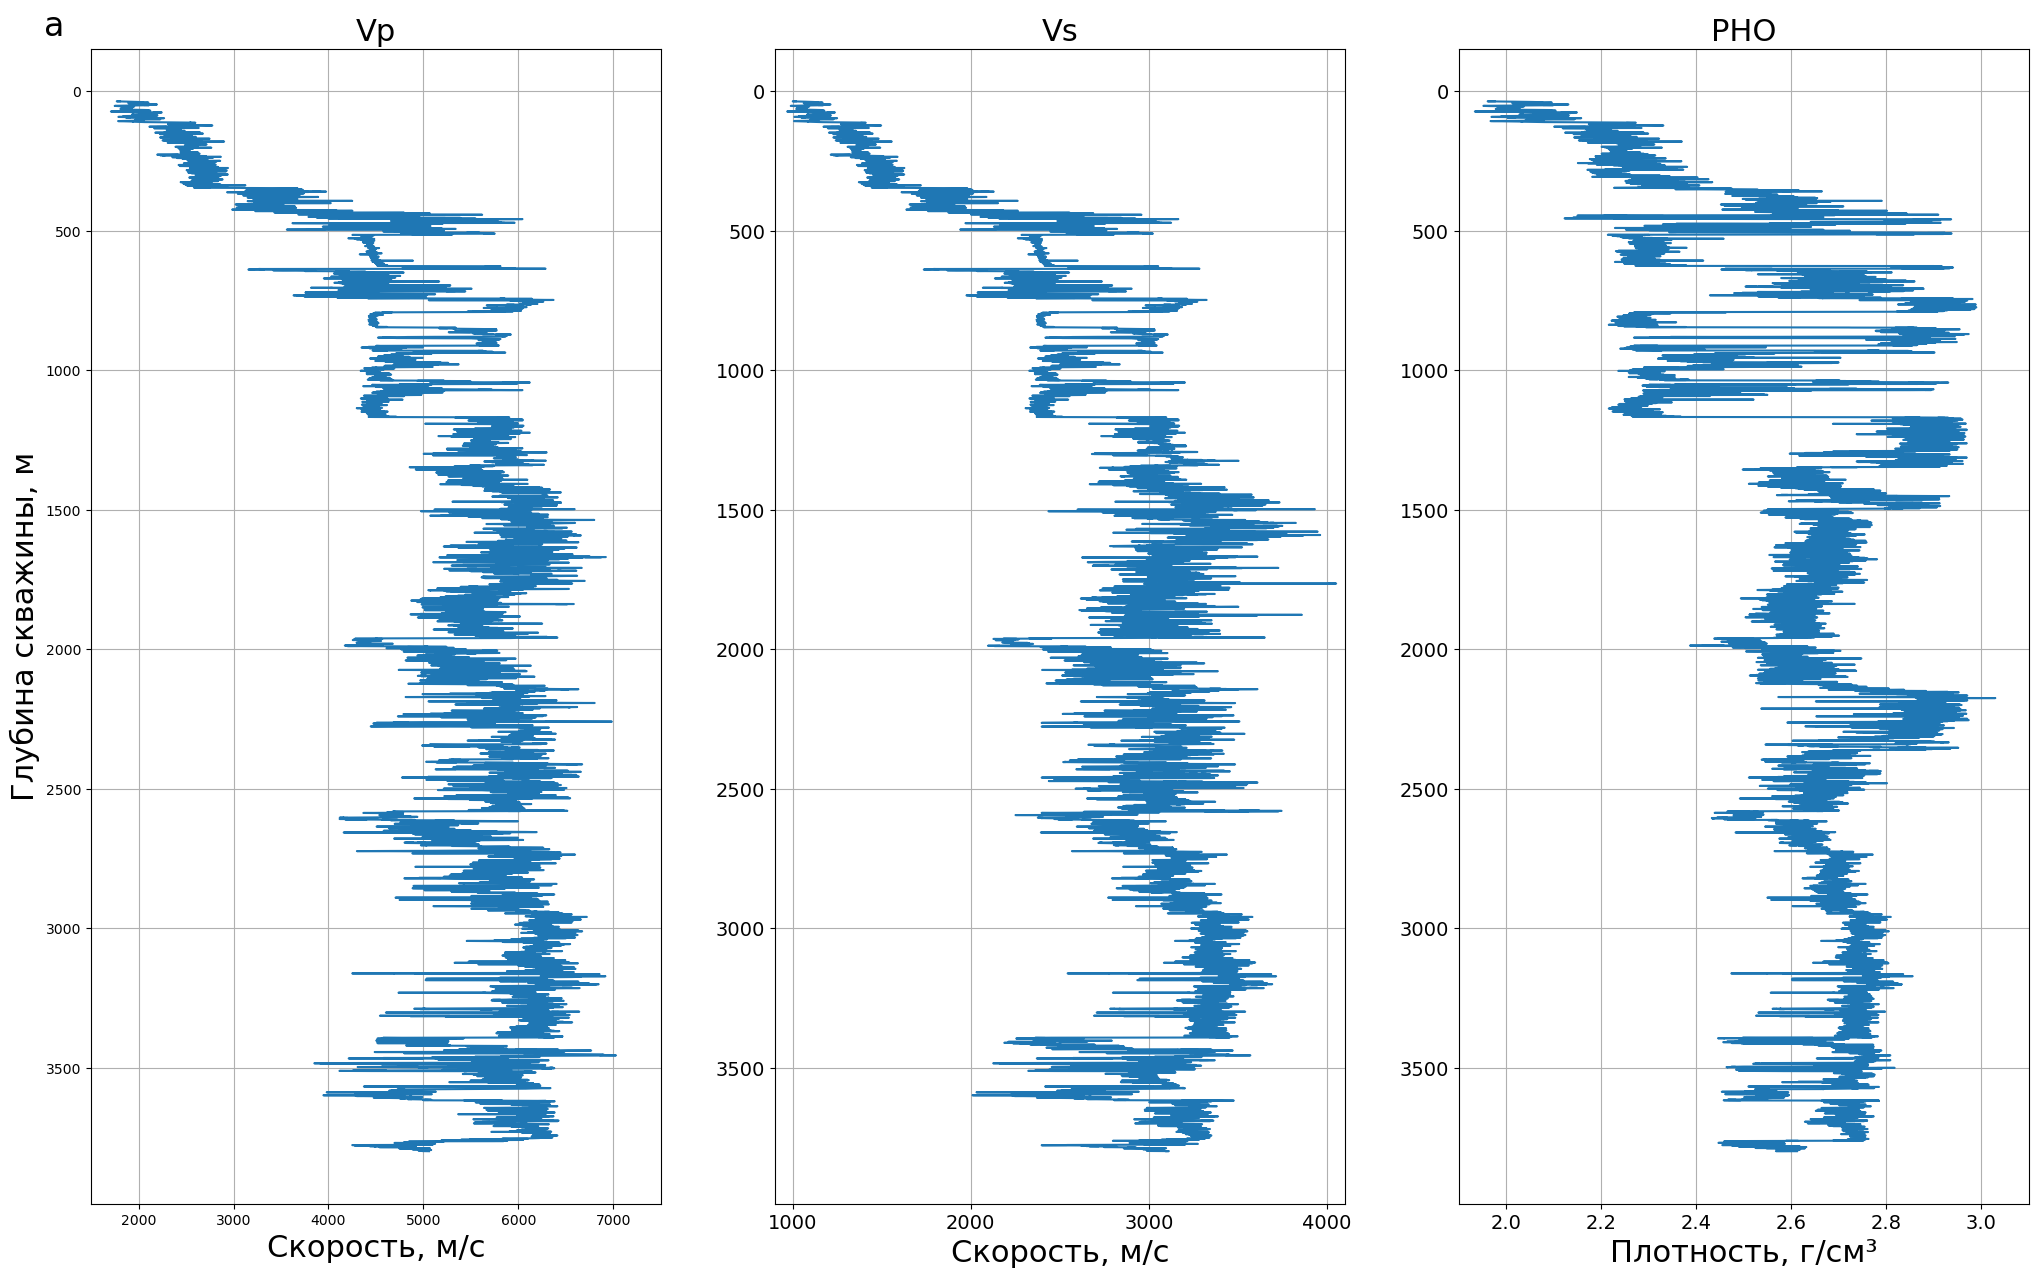

In [7]:
f_size = 22
lb_size = 14
lw = 0.7

plt.figure(figsize=(25, 15), frameon=True)

plt.subplot (1, 3, 1)
plt.plot(df['Vp'],df['H'])
plt.rc('ytick', labelsize= lb_size )
plt.rc('xtick', labelsize= lb_size )
plt.gca().invert_yaxis()
plt.title('Vp', fontsize=f_size)
plt.xlabel('Скорость, м/с', fontsize=f_size)
plt.ylabel('Глубина скважины, м', fontsize=f_size)
plt.xticks(np.arange(2000 , 7000 + 100, 1000))
plt.xlim(1500, 7500)
plt.text(1000, -200, f"a", fontsize = 24)
plt.grid()


plt.subplot (1, 3, 2)
plt.plot(df['Vs'],df['H'])
plt.rc('ytick', labelsize= lb_size )
plt.rc('xtick', labelsize= lb_size )
plt.gca().invert_yaxis()
plt.title('Vs', fontsize=f_size)
plt.xlabel('Скорость, м/с', fontsize=f_size)
plt.xticks(np.arange(1000 , 4000 + 100, 1000))
plt.xlim(900, 4100)
plt.grid()



plt.subplot (1, 3, 3)
plt.plot(df['RHO'],df['H'])
plt.rc('ytick', labelsize= lb_size ) 
plt.rc('xtick', labelsize= lb_size )
plt.gca().invert_yaxis()
plt.title('PHO', fontsize=f_size)
plt.xlabel('Плотность, г/см\u00B3', fontsize=f_size)
plt.xlim(1.9, 3.1)
plt.grid()

In [8]:
dh = 0.2
T_interval = []
T_interval.append(df['H'].values[0]/df['Vp'].values[0])
for i in range(len(df)-1):
    Vp_mean = np.mean(df['Vp'].values[i:i+2])
    T_interval.append(dh/Vp_mean)
df['T_interval'] = T_interval

In [9]:
T = []
T_tmp = 0
for i in range(len(df)):
    T_tmp = T_tmp+2*df['T_interval'].values[i]
    T.append(T_tmp)
df['T'] = T

In [185]:
dt_well = 1e-4#.008 /100

In [186]:
T_well = np.arange(df['T'].values[0],df['T'].values[-1],dt_well)
RHOB_int, Vp_int, Vs_int, DH_int = interpolate_parameters(T_well, df, 'T')

df_well = pd.DataFrame({'T_well':T_well,'V': Vp_int,'Vp':Vp_int,'Vs':Vs_int,'RHO':RHOB_int,'H':DH_int})

In [187]:
h0 = 5

T = []
H = df_well['H'].values
H = np.insert(H, 0, h0)

for i in range(len(df_well)):
    T.append( (H[i + 1] - H[i]) / df_well['V'][i]  )

df_well['T'] = T

In [188]:
''' Расчет коэф. отражения '''

Rpp_boundary = reflection_coef(df_well['V'].values, df_well['RHO'].values)

df_well['Rpp'] = Rpp_boundary

### Сейсмика +скв.

In [189]:

df_segy, traces = segy_file(filename3)
df_segy['Well_X'] = 9677130.991
df_segy['Well_Y'] = 5810082.313
T_segy = np.arange(0,traces.shape[1]*0.002,0.002)

df_segy['OFFSET'] = np.sqrt(((df_segy[['CDP_X', 'CDP_Y']].values - df_segy[['Well_X', 'Well_Y']].values) ** 2).sum(axis=1))
ind = df_segy[df_segy['OFFSET']==df_segy['OFFSET'].min()].index
trace_int=np.interp(T_well,T_segy,np.ravel(traces[ind,:].T))

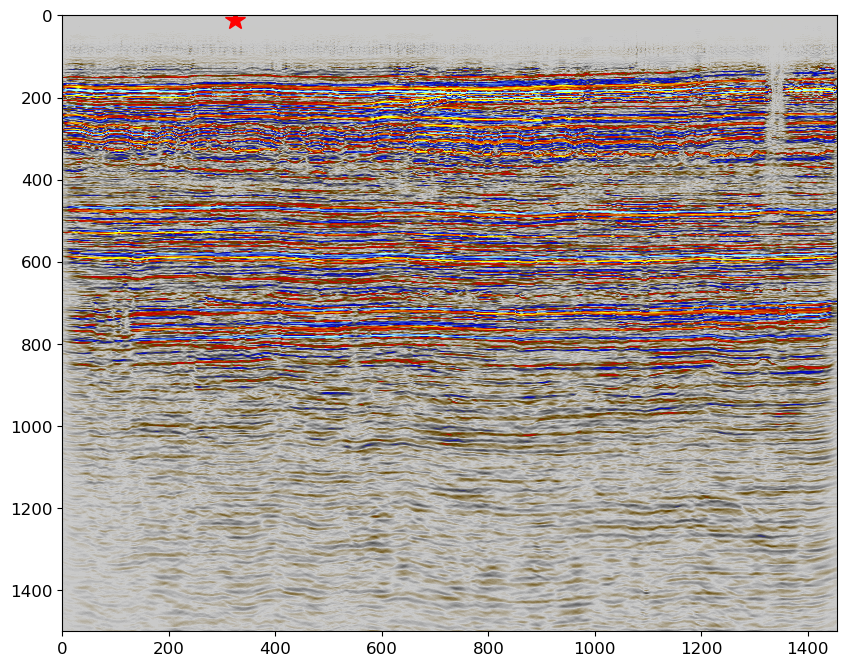

In [190]:
plt.figure(figsize = (10,8))
coef = 4
plt.imshow(trace3.T, aspect='auto',cmap = seismic(),
           vmin = np.mean(trace3) -coef*np.std(trace3),vmax = np.mean(trace3) +coef*np.std(trace3))
plt.plot(ind[0],10,'r*',markersize=15)

In [191]:
def IntervalData (T, TCut, dt):

    '''
    Функиця поиска индексов для обрезки данных в интервале

    Параметры
    --------------
    Вход:
        T - Регулярный вектор времен
        TCut - Регулярный временной интервал из Т
        dt - Шаг по времени (дискретизация) в с
        
    Выход:
        IndexMin - Индекс начала интервала
        IndexMax - Индекс конца интервала

    '''

    IndexMinTime = np.int32(np.min(TCut) / dt); IndexMaxTime = np.int32(np.max(TCut) / dt) + 1
    DopIndexTime = np.int32(np.min(T) / dt)

    IndexMin = IndexMinTime - DopIndexTime; IndexMax = IndexMaxTime - DopIndexTime

    if IndexMax - IndexMin != len(TCut):
        IndexMax += 1

    return IndexMin, IndexMax


def CutWavelet (Wavelet, WaveletLength, dt, alpha = 0.2, Taper = 0 ):

    '''
    Функиця обрезки вейвлета 

    Параметры
    --------------
    Вход:
        Wavelet - Сейсмический вейвлет
        WaveletLength - Длина импульса в мс
        dt - Шаг по времени (дискретизация) в с
        alpha - Параметр окна Tukey
        Taper - Количество дискретов для сглаживания на концах
        
    Выход:
        WaveletCut - Обрезанный и сглаженный вейвлет

    '''

    DT = dt * 1000
    WaveletCut = Wavelet[np.int32(len(Wavelet) / 2) - np.int32(WaveletLength / DT / 2): np.int32(len(Wavelet) / 2) + np.int32(WaveletLength / DT / 2) ]
    WaveletCut = WindowTukey (WaveletCut, alpha = alpha, Taper = Taper, dData = dt)

    return WaveletCut




def Autocorrelate (Trace, WaveletLength, dt, alpha = 0.2, Taper = 0):
    
    '''
    Функиця нахождения автокорреляционого вейвлета

    Параметры
    --------------
    Вход:
        Trace - Сейсмическая трасса 
        WaveletLength - Длина импульса в мс
        dt - Шаг по времени (дискретизация) в с

    Выход:
        Wavelet - Оцененный автокорреляцией вейвлет
        TimeWavelet - Регулярный вектор времен вейвлета

    '''

    DT = dt * 1000
    AutocorrelateTrace = np.correlate(Trace, Trace, mode='full')

    # Wavelet = AutocorrelateTrace
    Wavelet = CutWavelet (AutocorrelateTrace, WaveletLength, dt, alpha = alpha, Taper = Taper )

    # WaveletAdd = np.zeros((np.int32(len(AutocorrelateTrace) / 2) - np.int32(WaveletLength / DT / 2)))
    # Wavelet = np.hstack((Wavelet, WaveletAdd))
    # Wavelet = np.insert(Wavelet, 0, WaveletAdd)

    CountZeros = (np.int32(len(AutocorrelateTrace) / 2) - np.int32(WaveletLength / DT / 2))
    Wavelet = AdditionZeros (Wavelet, CountZeros)

    TimeWavelet = np.linspace(-len(Wavelet) / 2 * dt, len(Wavelet) / 2 * dt, len(Wavelet))

    return Wavelet, TimeWavelet


def WindowTukey (Data, alpha = 0.2, Taper = 0, dData = 0):
    
    '''
    Функиця сглаживания данных окном Tukey. 2 варианта:
                                                        - Заданным параметром Tukey
                                                        - Рассчитанным параметром из количества дискретов для сглаживания 

    Параметры
    --------------
    Вход:
        Data - Данные 
        alpha - Параметр окна Tukey
        Taper - Количество дискретов для сглаживания на концах 
        dData - Дискретизация данных

        
    Выход:
        DataTukey - Сглаженные данные

    '''
    
    if Taper != 0 and dData != 0:
        Window = signal.tukey(len(Data), ((Taper / (dData * 1000)) / len(Data)) * 2)

    else:
        Window = signal.tukey(len(Data),alpha = alpha)
    DataTukey = Data * Window

    return DataTukey 

def AdditionZeros (Data, CountZeros):

    AddZeros = np.zeros((CountZeros))
    DataNew = np.hstack((Data, AddZeros))
    DataNew = np.insert(DataNew, 0, AddZeros)

    return DataNew


def ShiftData (Data, TimeShift, dt):

    '''
    Функция расчета сдвинутых данных
    
    Параметры
    --------------
    Вход:
        Data - Массив данных
        dt - Шаг по времени (дискретизация) в с
        TimeShift - Сдвиг (в мс)

    Выход:
        DataShift - Сдвинутые данные    
    
    '''

    TimeShift_tmp = TimeShift / 1000

    shift = np.int32( (TimeShift_tmp / dt ))
    Index = np.abs(shift)

    DataAdd = np.zeros((np.abs(shift)))

    if shift < 0:
        DataShift = Data[Index:]
        DataShift = np.hstack((DataShift, DataAdd))
    elif shift > 0:
        DataShift = Data[:-Index]
        DataShift =  np.insert(DataShift, 0,  DataAdd)
    else:
        DataShift = Data

    return DataShift


def ConstanPhase (signal, phase):

    '''
    ??????????????
    '''
    
    B_spec = np.fft.fft(signal)
    B_amp = np.sqrt(np.abs(B_spec))

    B_faz = np.ones(len(B_amp))
    B_faz[:int(len(B_amp)/2)] *= -1
    B_faz[int(len(B_amp)/2)] = 0
    B_faz *= phase

    nprect = np.vectorize(cmath.rect)
    
    return nprect(B_amp, B_faz)

def ZeroPhase(signal):

    B_spec = np.fft.fft(signal)
    B_amp = np.sqrt(np.abs(B_spec))
    B_faz = np.zeros((len(B_spec)))

    nprect = np.vectorize(cmath.rect)

    return nprect(B_amp, B_faz)

def to_minphase2(signal):
    if (len(signal.shape) != 1):
        raise VectorShapeException("Vector shape is incorrect")
    if (signal.size == 0):
        raise VectorSizeException("Vector size is incorrect")

    B_spec = np.fft.fft(signal)
    B_amp = np.sqrt(np.abs(B_spec))
    B_faz = -np.imag(hilbert2(np.log(B_amp+1e-6)))
   
    nprect = np.vectorize(cmath.rect)
    
    return nprect(B_amp, B_faz)
    
def hilbert2(signal):
    signal_spec = np.fft.fft(signal)
    freq = np.fft.fftfreq(len(signal_spec))
    signal_spec[np.where(freq < 0)] = 0
    signal_spec[np.where(freq > 0)] = signal_spec[np.where(freq > 0)] * 2
    hilb_fft = np.fft.ifft(signal_spec)

    return hilb_fft


def FFT(Data, dt, phase = False):

    Spec = np.fft.rfft(Data)
    Amp = np.abs(Spec)
    Phase = np.angle(Spec)
    Freq = np.fft.rfftfreq(len(Data), d = dt)
    if phase:
        return Freq, Amp, Phase
    else:
        return Freq, Amp 

In [192]:
def ComplexConjugate (Data):
    '''
    Функция расчета прямого преобразования Фурье и его комплексного сопряженного вектора
    
    Параметры
    --------------
    Вход:
        Data - Сейсмическая трасса 

    Выход:
        SpectrumData - Прямое преобразование Фурье
        SpectrumDataConjugate - Комплексный сопряженный вектор    
    
    '''

    SpectrumData = np.fft.fft(Data)
    SpectrumDataConjugate = SpectrumData.conjugate()

    return SpectrumData, SpectrumDataConjugate


def Coherence (Trace, Rpp, Stab = 1e-6):
    '''
    Функция расчета когерентности сейсмической трассы и коэффициентов отражений   
    
    Параметры
    --------------
    Вход:
        Trace - Сейсмическая трасса 
        Rpp - Коэффициенты отражений
        Stab - Коэффициент стабильности (который делает деление стабильным)

    Выход:
        coherence - Когерентность сейсмической трассы и коэффициентов отражений    
    
    '''

    SpecTrace, SpecTraceConjugate = ComplexConjugate (Trace)
    SpecRpp, SpecRppConjugate = ComplexConjugate (Rpp)

    Numerator = (np.sum(SpecRppConjugate * SpecTrace)) ** 2
    Denominator = (np.sum(SpecRppConjugate * SpecRpp + Stab)) * np.sum(SpecTraceConjugate * SpecTrace)
    
    coherence = Numerator / Denominator

    return coherence

def CoherenceShift (Trace, Rpp, dt, Shift, Stab = 1e-6):

    '''
    Функция расчета когерентности сейсмической трассы и коэффициентов отражений при сдвиге
    
    Параметры
    --------------
    Вход:
        Trace - Сейсмическая трасса 
        Rpp - Коэффициенты отражений
        dt - Шаг по времени (дискретизация) в с
        Shift - Пределы сдвига коэффициентов отражений (в мс)
        Stab - Коэффициент стабильности (который делает деление стабильным)

    Выход:
        coherence - Когерентность сейсмической трассы и коэффициентов отражений    
    
    '''

    DT = dt * 1000

    if Shift == 0:
        return Rpp, Trace, Shift
    
    TimeShift = np.arange(-Shift/1000, Shift/1000 + 2 * dt, dt)

    CountZeros = np.int32(Shift / DT)

    TraceZeros = AdditionZeros (Trace, CountZeros)
    RppZeros = AdditionZeros (Rpp, CountZeros)

    SpectrumTrace, SpectrumTraceConjugate = ComplexConjugate (TraceZeros)

    G = np.zeros((len(TimeShift)))
    RppShift = np.zeros((len(TimeShift), len(RppZeros)))

    for i in range(len(TimeShift)):

        RppShift[i] = ShiftData (RppZeros, TimeShift[i] * 1000, dt)

        SpectrumRpp, SpectrumRppConjugate = ComplexConjugate (RppShift[i])

        Numerator = (np.sum(SpectrumRppConjugate * SpectrumTrace)) ** 2
        Denominator = (np.sum(SpectrumRppConjugate * SpectrumRpp + Stab)) * np.sum(SpectrumTraceConjugate * SpectrumTrace)
    
        G[i] = Numerator / Denominator

    N = np.argmax(G)
    

    return RppShift[N], TraceZeros, TimeShift[N]


def CoherenceShiftRpp (Trace, Rpp, IndexMin, IndexMax, dt, Shift, dShift = 1, Stab = 1e-6):

    '''
    Функция расчета когерентности сейсмической трассы и коэффициентов отражений при сдвиге
    
    Параметры
    --------------
    Вход:
        Trace - Сейсмическая трасса 
        Rpp - Коэффициенты отражений
        IndexMin - Индекс начала интервала
        IndexMax - Индекс конца интервала
        dt - Шаг по времени (дискретизация) в с
        Shift - Пределы сдвига коэффициентов отражений (в мс)
        dShift - Шаг для сдвига (в мс)
        Stab - Коэффициент стабильности (который делает деление стабильным)

    Выход:
        RppShift[N] - Свинутые коэффициенты корреляции
        TimeShift[N] - Временной сдвиг для наибольшей когерентности 
    
    '''

    if Shift == 0:
        RppShift = Rpp[IndexMin:IndexMax]
        return RppShift, 0

    DT = dt * 1000
    IndexShift = np.int32(Shift /  (DT) )
    IndexdShift = np.int32(dShift /  (DT) )

    SpectrumTrace, SpectrumTraceConjugate = ComplexConjugate (Trace)

    CountShift = np.int32((Shift / dShift) * 2)

    TimeShift = np.zeros((CountShift))
    G = np.zeros((CountShift))
    RppShift = np.zeros((CountShift, len(Trace)))

    for i in range(RppShift.shape[0]):

        TimeShift[i] = (- IndexShift + IndexdShift * i) * dt
        RppShift[i, :] = Rpp[IndexMin - IndexShift + IndexdShift * i:IndexMax - IndexShift + IndexdShift * i]
        SpectrumRpp, SpectrumRppConjugate = ComplexConjugate (RppShift[i])

        Numerator = (np.sum(SpectrumRppConjugate * SpectrumTrace)) ** 2
        Denominator = (np.sum(SpectrumRppConjugate * SpectrumRpp + Stab)) * np.sum(SpectrumTraceConjugate * SpectrumTrace)
        G[i] = Numerator / Denominator

    N = np.argmax(G)

    return RppShift[N], TimeShift[N]

In [193]:
def StatisticMinPhaseMethod (Trace, T, TCut, dt, WaveletLength, SigmaAutocor, alpha = 0.2, Taper = 0):

    '''
    Функиця извлечения импульса статистическим методом

    Параметры
    --------------
    Вход:
        Trace - Сейсмическая трасса 
        T - Регулярный вектор времен трассы
        TCut - Регулярный временной отрезок, из которого извлечается импульс
        dt - Шаг по времени (дискретизация) в с
        WaveletLength - Длина импульса в мс

        SigmaAutocor -
        alpha - 
        Taper - Длина сглаживания на концах
    
    Выход:
        Wavelet - Оцененный импульс
        TimeWavelet - Регулярный вектор времен импульс

    '''

    IndexMin, IndexMax = IntervalData(T, TCut, dt)
    TraceCut = Trace[IndexMin:IndexMax]

    WaveletAutocor, TimeWavelet = Autocorrelate (TraceCut, WaveletLength, dt, alpha = alpha, Taper = Taper)
    WaveletAutocorGaussian = gaussian_filter(WaveletAutocor, sigma = SigmaAutocor)

    WaveletFrequency = to_minphase2(WaveletAutocorGaussian)
    Wavelet_tmp = np.real(np.fft.ifftshift(np.fft.ifft(WaveletFrequency)))
    
    Wavelet = CutWavelet (Wavelet_tmp, WaveletLength, dt, alpha = alpha, Taper = Taper )
    TimeWavelet = np.linspace(-WaveletLength / 2, WaveletLength / 2, len(Wavelet))
    
    return Wavelet, TimeWavelet



def StatisticMethod (Trace, T, TCut, dt, WaveletLength, SigmaAutocor, alpha = 0.2, Taper = 0):

    '''
    Функиця извлечения импульса статистическим методом

    Параметры
    --------------
    Вход:
        Trace - Сейсмическая трасса 
        T - Регулярный вектор времен трассы
        TCut - Регулярный временной отрезок, из которого извлечается импульс
        dt - Шаг по времени (дискретизация) в с
        WaveletLength - Длина импульса в мс

        SigmaAutocor -
        alpha - 
        Taper - Длина сглаживания на концах
    
    Выход:
        Wavelet - Оцененный импульс
        TimeWavelet - Регулярный вектор времен импульс

    '''

    IndexMin, IndexMax = IntervalData(T, TCut, dt)
    TraceCut = Trace[IndexMin:IndexMax]

    WaveletAutocor, TimeWavelet = Autocorrelate (TraceCut, WaveletLength, dt, alpha = alpha, Taper = Taper)
    WaveletAutocorGaussian = gaussian_filter(WaveletAutocor, sigma = SigmaAutocor)

    WaveletFrequency =  ZeroPhase(WaveletAutocorGaussian)
    Wavelet_tmp = np.real(np.fft.ifftshift(np.fft.ifft(WaveletFrequency)))

    Wavelet = CutWavelet (Wavelet_tmp, WaveletLength, dt, alpha = alpha, Taper = Taper )
    TimeWavelet = np.linspace(-WaveletLength / 2, WaveletLength / 2, len(Wavelet))
    
    return Wavelet, TimeWavelet


def FullWaveletMethod (Trace, Rpp, T, TCut, WaveletLength, dt, SigmaAutocor, alpha = 0.2, Taper = 0 ):
    
    '''
    Функиця извлечения импульса детерменистическим методом полного вейвлета

    Параметры
    --------------
    Вход:
        Trace - Сейсмическая трасса 
        T - Регулярный вектор времен трассы
        TCut - Регулярный временной отрезок, из которого извлечается импульс
        dt - Шаг по времени (дискретизация) в с
        WaveletLength - Длина импульса в мс

        alpha - 
        Taper - Длина сглаживания на концах

    Выход:
        Wavelet - Оцененный импульс
        TimeWavelet - Регулярный вектор времен импульс

    '''

    IndexMin, IndexMax = IntervalData(T, TCut, dt)
    TraceCut = Trace[IndexMin:IndexMax]; RppCut = Rpp[IndexMin:IndexMax]

    TraceCut = WindowTukey (TraceCut, alpha = 0.1, Taper = 0, dData = dt)
    RppCut = WindowTukey (RppCut, alpha = 0.1, Taper = 0, dData = dt)

    DT = dt * 1000

    WaveletLength_tmp = int(WaveletLength / DT / 2) * 2

    mult_ref_coeff = np.zeros([len(TraceCut), WaveletLength_tmp])
    WaveletLengthHalf = int(np.round(WaveletLength_tmp / 2))
    for jj in range(np.shape(mult_ref_coeff)[1]):
        if WaveletLengthHalf - jj >= 0:
            end_index = len(RppCut) - WaveletLengthHalf + jj
            start_index = WaveletLengthHalf - jj
            mult_ref_coeff[0:end_index, jj] = RppCut[start_index:]
        else:
            end_index = len(RppCut) + WaveletLengthHalf - jj
            start_index = jj - WaveletLengthHalf
            mult_ref_coeff[start_index:, jj] = RppCut[0:end_index]
    Wavelet = np.linalg.pinv(mult_ref_coeff.T.dot(mult_ref_coeff), rcond=1e-10)
    Wavelet = Wavelet.dot(mult_ref_coeff.T.dot(TraceCut))

    Wavelet = gaussian_filter(Wavelet, sigma = SigmaAutocor)

    Wavelet = WindowTukey (Wavelet, alpha = alpha, Taper = Taper, dData = dt)

    TimeWavelet = np.linspace(-WaveletLength / 2, WaveletLength / 2, len(Wavelet))

    return Wavelet, TimeWavelet


def RoyWhiteMethod (Trace, T, TCut, dt, Rpp, Shift, SigmaAutocor, dShift = 1, Stab = 1e-6, alpha = 0.2, Taper = 0 ):

    '''
    Функиця извлечения импульса детерминистическим методом Роя Уайта

    Параметры
    --------------
    Вход:
        Trace - Сейсмическая трасса 
        T - Регулярный вектор времен трассы
        TCut - Регулярный временной отрезок, из которого извлечается импульс
        w_length - Длина импульса в мс
        taper_impulse_extr - Длина сглаживания на концах

        dt - Шаг по времени (дискретизация) в с

        
    Выход:
        impulse - Оцененный импульс
        time_impuls - Регулярный вектор времен импульс

    '''
    
    IndexMin, IndexMax = IntervalData(T, TCut, dt)
    TraceCut = Trace[IndexMin:IndexMax]

    RppCut, TimeShift = CoherenceShiftRpp (TraceCut, Rpp, IndexMin, IndexMax, dt, Shift, dShift = dShift, Stab = 1e-6)

    TraceCut = WindowTukey (TraceCut, alpha = 0.1, Taper = 0, dData = dt)
    RppCut = WindowTukey (RppCut, alpha = 0.1, Taper = 0, dData = dt)

    SpectrumRpp, SpectrumRppConjugate = ComplexConjugate (RppCut)
    SpectrumTrace = np.fft.fft(TraceCut)
    Numerator = SpectrumRppConjugate * SpectrumTrace
    Denominator = SpectrumRppConjugate * SpectrumRpp + Stab

    WaveletFrequency = Numerator / Denominator
    
    Wavelet = np.real(np.fft.ifftshift(np.fft.ifft(WaveletFrequency))) 

    Wavelet -= np.mean(Wavelet)

    Wavelet = WindowTukey (Wavelet, alpha = alpha, Taper = Taper, dData = dt)
    Wavelet = gaussian_filter(Wavelet,SigmaAutocor)
    Wavelet = WindowTukey (Wavelet, alpha = alpha, Taper = Taper, dData = dt)

    TimeWavelet = np.linspace(-len(Wavelet) / 2 * dt, len(Wavelet) / 2 * dt, len(Wavelet))

    return Wavelet, TimeWavelet, TimeShift


def RoyWhiteMethod_ (Trace, T, TCut, dt, Rpp, Shift, SigmaAutocor, alpha = 0.2, Taper = 0, Stab = 1e-6):

    '''
    Функиця извлечения импульса детерминистическим методом Роя Уайта

    Параметры
    --------------
    Вход:
        Trace - Сейсмическая трасса 
        T - Регулярный вектор времен трассы
        TCut - Регулярный временной отрезок, из которого извлечается импульс
        w_length - Длина импульса в мс
        taper_impulse_extr - Длина сглаживания на концах

        dt - Шаг по времени (дискретизация) в с

        
    Выход:
        impulse - Оцененный импульс
        time_impuls - Регулярный вектор времен импульс

    '''
    
    IndexMin, IndexMax = IntervalData(T, TCut, dt)
    TraceCut = Trace[IndexMin:IndexMax]; RppCut = Rpp[IndexMin:IndexMax]

    RppCut, TraceCut, TimeShift = CoherenceShift (TraceCut, RppCut, dt, Shift, Stab = Stab)

    TraceCut = WindowTukey (TraceCut, alpha = 0.1, Taper = 0, dData = dt)
    RppCut = WindowTukey (RppCut, alpha = 0.1, Taper = 0, dData = dt)

    SpectrumRpp, SpectrumRppConjugate = ComplexConjugate (RppCut)
    SpectrumTrace = np.fft.fft(TraceCut)
    Numerator = SpectrumRppConjugate * SpectrumTrace
    Denominator = SpectrumRppConjugate * SpectrumRpp + Stab

    WaveletFrequency = Numerator / Denominator
    Wavelet = np.real(np.fft.ifftshift(np.fft.ifft(WaveletFrequency))) 

    Wavelet -= np.mean(Wavelet)

    Wavelet = WindowTukey (Wavelet, alpha = alpha, Taper = Taper, dData = dt)
    Wavelet = gaussian_filter(Wavelet,SigmaAutocor)
    Wavelet = WindowTukey (Wavelet, alpha = alpha, Taper = Taper, dData = dt)

    TimeWavelet = np.linspace(-len(Wavelet) / 2 * dt, len(Wavelet) / 2 * dt, len(Wavelet))

    return Wavelet, TimeWavelet, TimeShift

In [194]:
def backus_filter(time_values, function_values, length):
    """
    Function Backus filtering
    Args:
        time_values: array of time values
        function_values: array of function values
        length: window length
    Returns:
        F_back: smoothed function values`
    """
    if not len(time_values) == len(function_values):
        raise ValueError("time_values and function_values length must be equal")
    if length <= 0:
        raise ValueError("length must be > 0")

    sigma = length * length
    dt = np.abs(time_values[1] - time_values[0])
    f_back = np.copy(function_values)
    for i in range(len(function_values)):
        mu = time_values[i]
        omega = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(
            -(time_values - mu) * (time_values - mu) / (2 * sigma * sigma)
        )
        f_back[i] = np.sum(omega * function_values) * dt
    return f_back


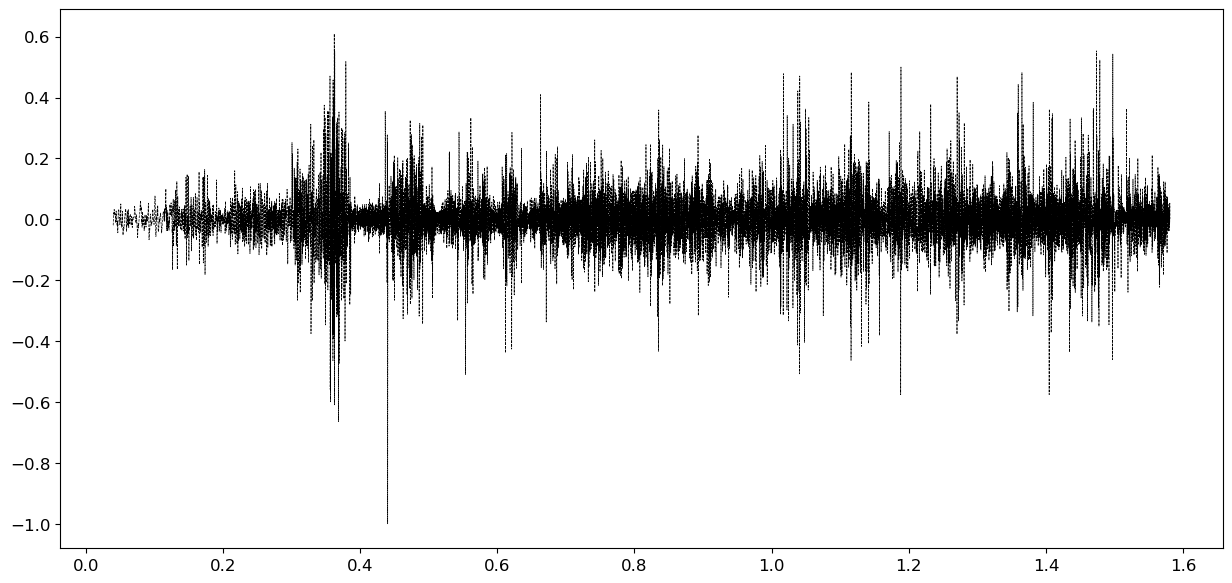

In [195]:
Trace = trace_int.copy()
Rpp = Rpp_boundary.copy()
T = T_well.copy()

dt = dt_well
# RppFilt = backus_filter(T, Rpp, dt * 200)

plt.figure (figsize = (15, 7))

plt.plot(T, Rpp/np.max(np.abs(Rpp)), '--k', lw = 0.5, label = 'Primary')
# plt.plot(T, RppFilt/np.max(np.abs(RppFilt)), '--c', lw = 2, label = 'Smooth')

C:\Temp\ipykernel_5760\3153116503.py:93: ComplexWarning: Casting complex values to real discards the imaginary part
  G[i] = Numerator / Denominator


Text(0, 0.5, 'Амплитуда')

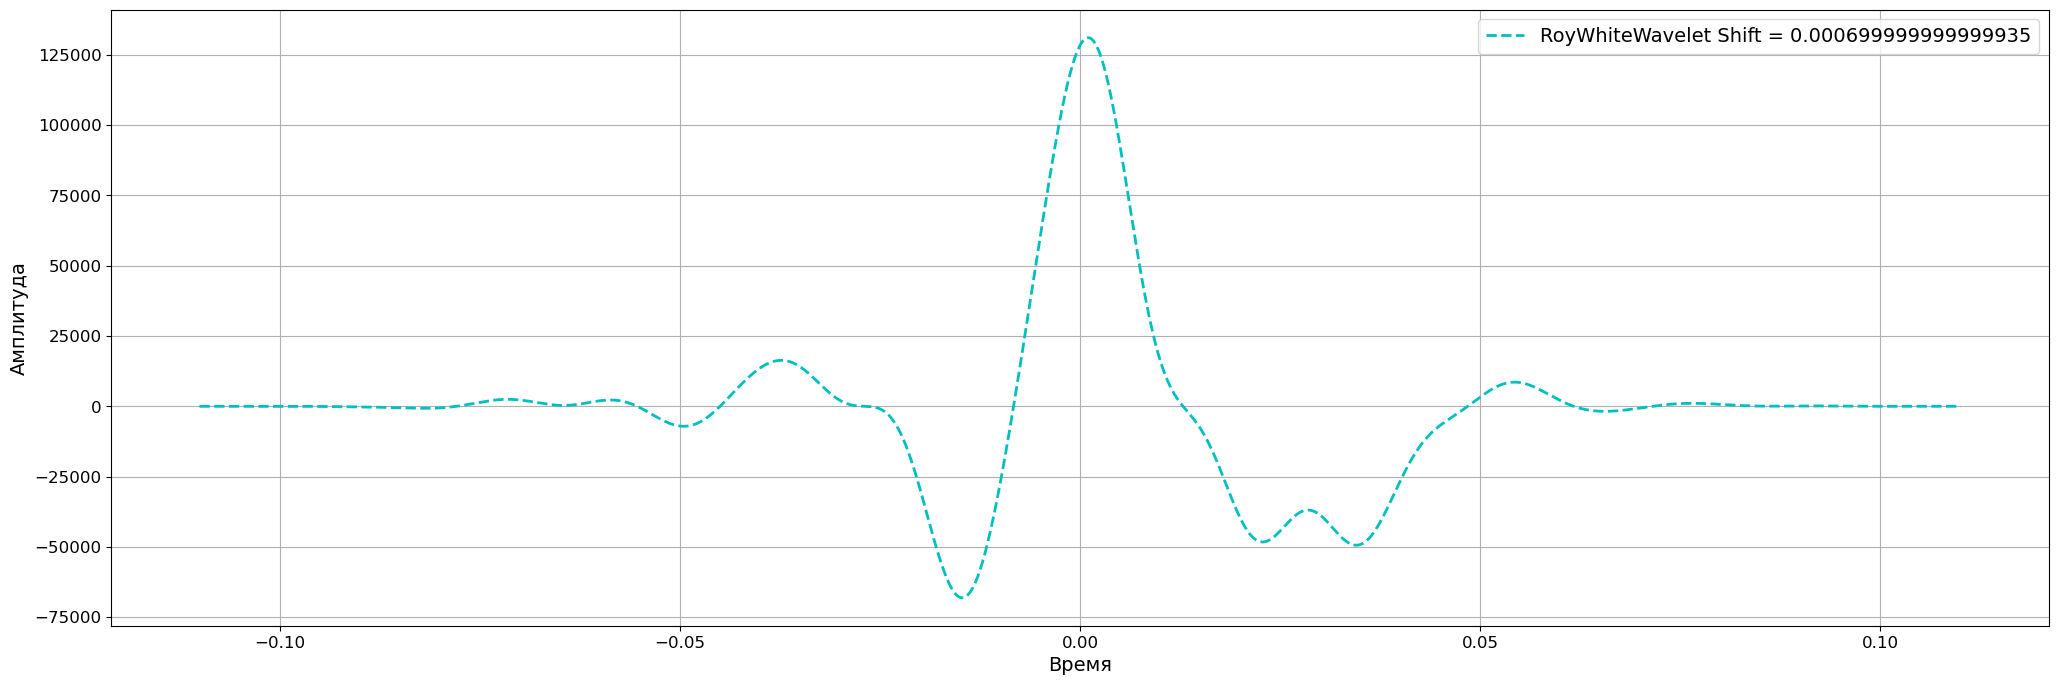

In [197]:
Trace = trace_int.copy()
Rpp = Rpp_boundary.copy()
T = T_well.copy()
dt = dt_well

TCut = np.arange(.6, .8, dt)
WaveletLength = 0
SigmaAutocor = 35
Shift = 10

Taper = 0


RoyWhiteWavelet_, TimeWavelet_3_, TimeShift_ = RoyWhiteMethod_ (Trace, T, TCut, dt, Rpp, Shift, SigmaAutocor, alpha = 1, Taper = Taper, Stab = 1e-6)

RoyWhiteWavelet_ = ShiftData (RoyWhiteWavelet_, TimeShift_ * 1000, dt)


norm = 0

plt.figure(figsize = (25, 8))
if norm == 1:
    plt.plot(TimeWavelet_3_, RoyWhiteWavelet_/np.max(RoyWhiteWavelet_), '-', color = 'c', lw = 2, label = f'RoyWhiteWavelet Shift = {TimeShift_}')
else:
    plt.plot(TimeWavelet_3_, RoyWhiteWavelet_, '--', color = 'c', lw = 2, label = f'RoyWhiteWavelet Shift = {TimeShift_}')

plt.legend(fontsize = 14)
plt.grid(':')
plt.xlabel('Время', fontsize = 14)
plt.ylabel('Амплитуда', fontsize =14)

-0.001


C:\Temp\ipykernel_5760\3153116503.py:148: ComplexWarning: Casting complex values to real discards the imaginary part
  G[i] = Numerator / Denominator


Text(0, 0.5, 'Амплитуда')

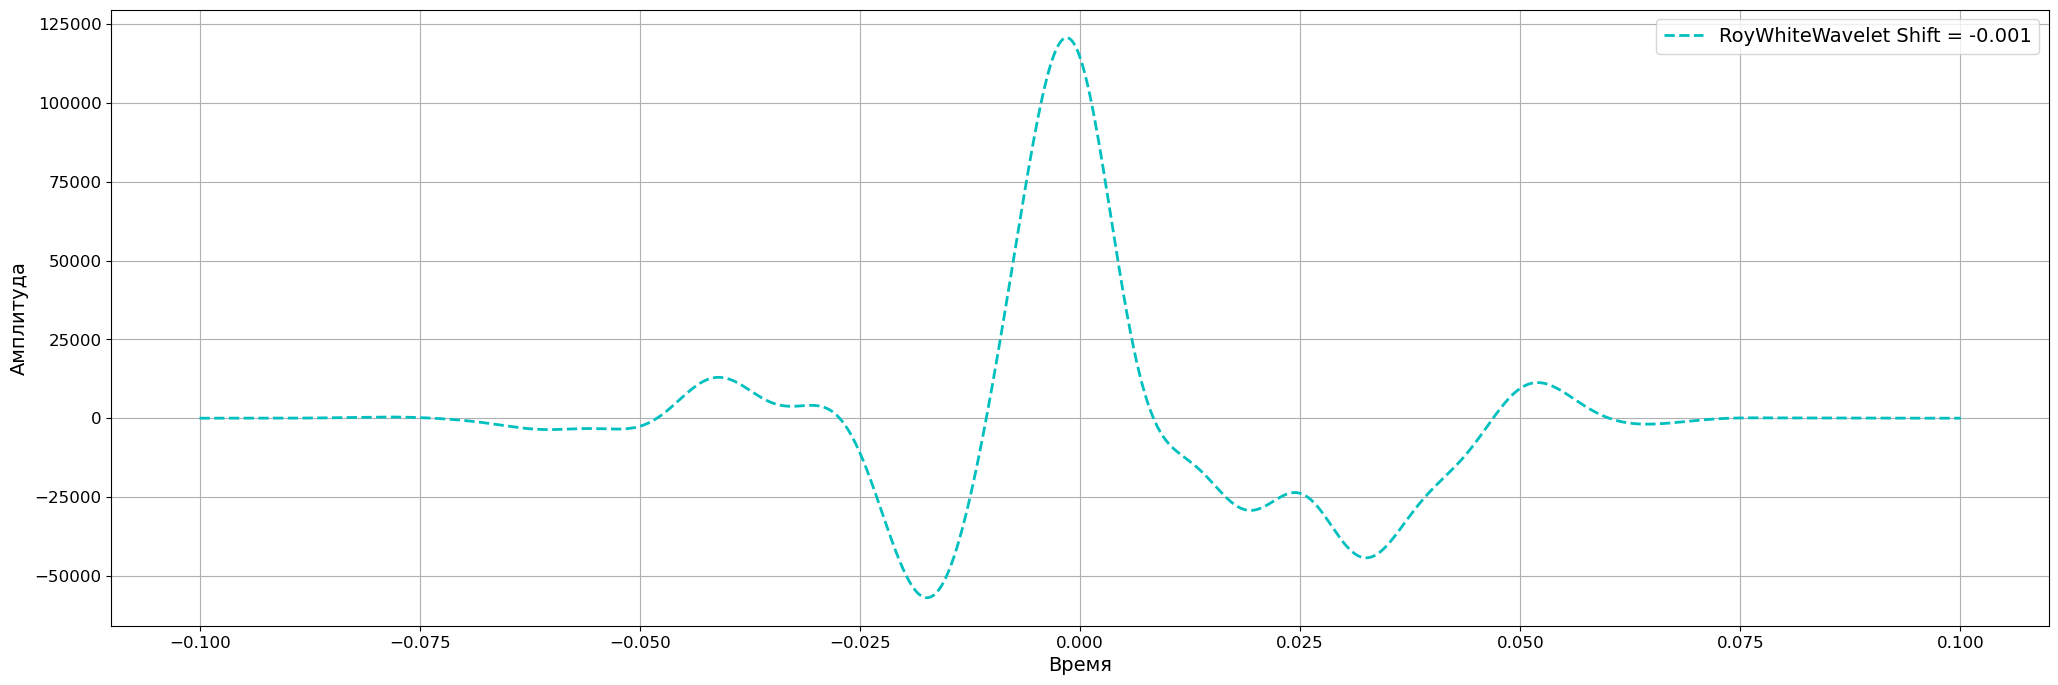

In [198]:
Trace = trace_int.copy()
Rpp = Rpp_boundary.copy()
T = T_well.copy()
dt = dt_well


TCut = np.arange(.6, .8, dt)
WaveletLength = 0
SigmaAutocor = 35
Shift = 100

Taper = 0

RoyWhiteWavelet, TimeWavelet_3, TimeShift = RoyWhiteMethod (Trace, T, TCut, dt, Rpp, Shift, SigmaAutocor, dShift = 1, Stab = 1e-6, alpha = 1, Taper = Taper )


RoyWhiteWavelet = ShiftData (RoyWhiteWavelet, TimeShift * 1000, dt)
print(TimeShift)
norm = 0

plt.figure(figsize = (25, 8))
if norm == 1:
    plt.plot(TimeWavelet_3, RoyWhiteWavelet/np.max(RoyWhiteWavelet), '-', color = 'c', lw = 2, label = f'RoyWhiteWavelet Shift = {TimeShift}')
else:
    plt.plot(TimeWavelet_3, RoyWhiteWavelet, '--', color = 'c', lw = 2, label = f'RoyWhiteWavelet Shift = {TimeShift}')

plt.legend(fontsize = 14)
plt.grid(':')
plt.xlabel('Время', fontsize = 14)
plt.ylabel('Амплитуда', fontsize =14)

Text(0, 0.5, 'Амплитуда')

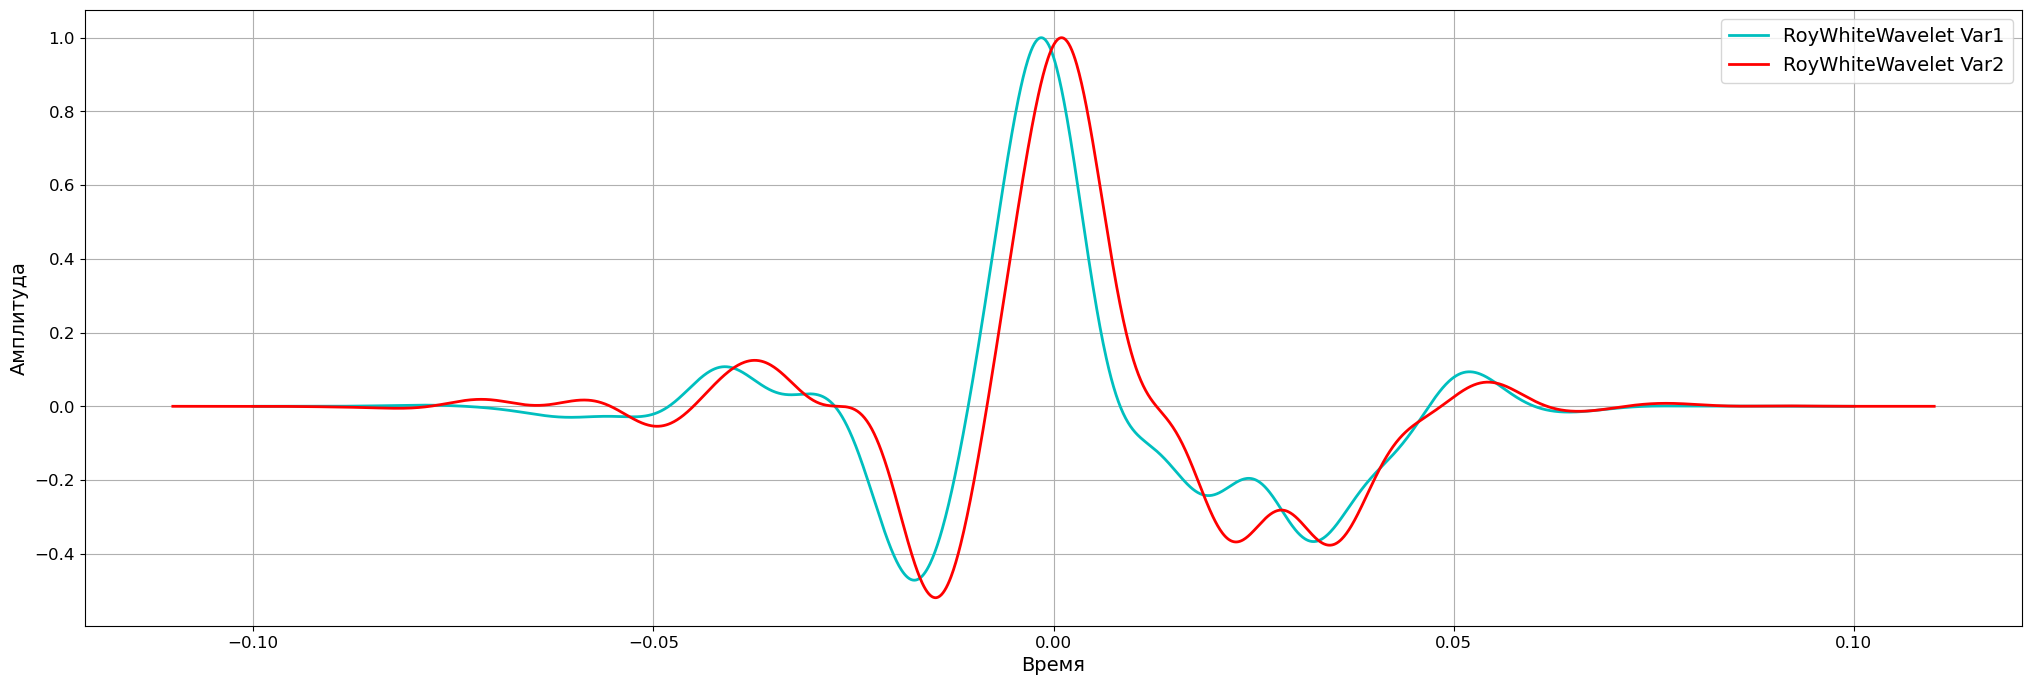

In [200]:
plt.figure(figsize = (25, 8))

norm = 1
if norm == 1:
    plt.plot(TimeWavelet_3, RoyWhiteWavelet/np.max(RoyWhiteWavelet), '-', color = 'c', lw = 2, label = f'RoyWhiteWavelet Var1')
    plt.plot(TimeWavelet_3_, RoyWhiteWavelet_/np.max(RoyWhiteWavelet_), '-', color = 'r', lw = 2, label = f'RoyWhiteWavelet Var2')
    
else:
    plt.plot(TimeWavelet_3, RoyWhiteWavelet, '-', color = 'c', lw = 2, label = f'RoyWhiteWavelet Var1')
    plt.plot(TimeWavelet_3_, RoyWhiteWavelet_, '-', color = 'r', lw = 2, label = f'RoyWhiteWavelet Var2')

plt.legend(fontsize = 14)
plt.grid(':')
plt.xlabel('Время', fontsize = 14)
plt.ylabel('Амплитуда', fontsize =14)

Text(0, 0.5, 'Амплитуда')

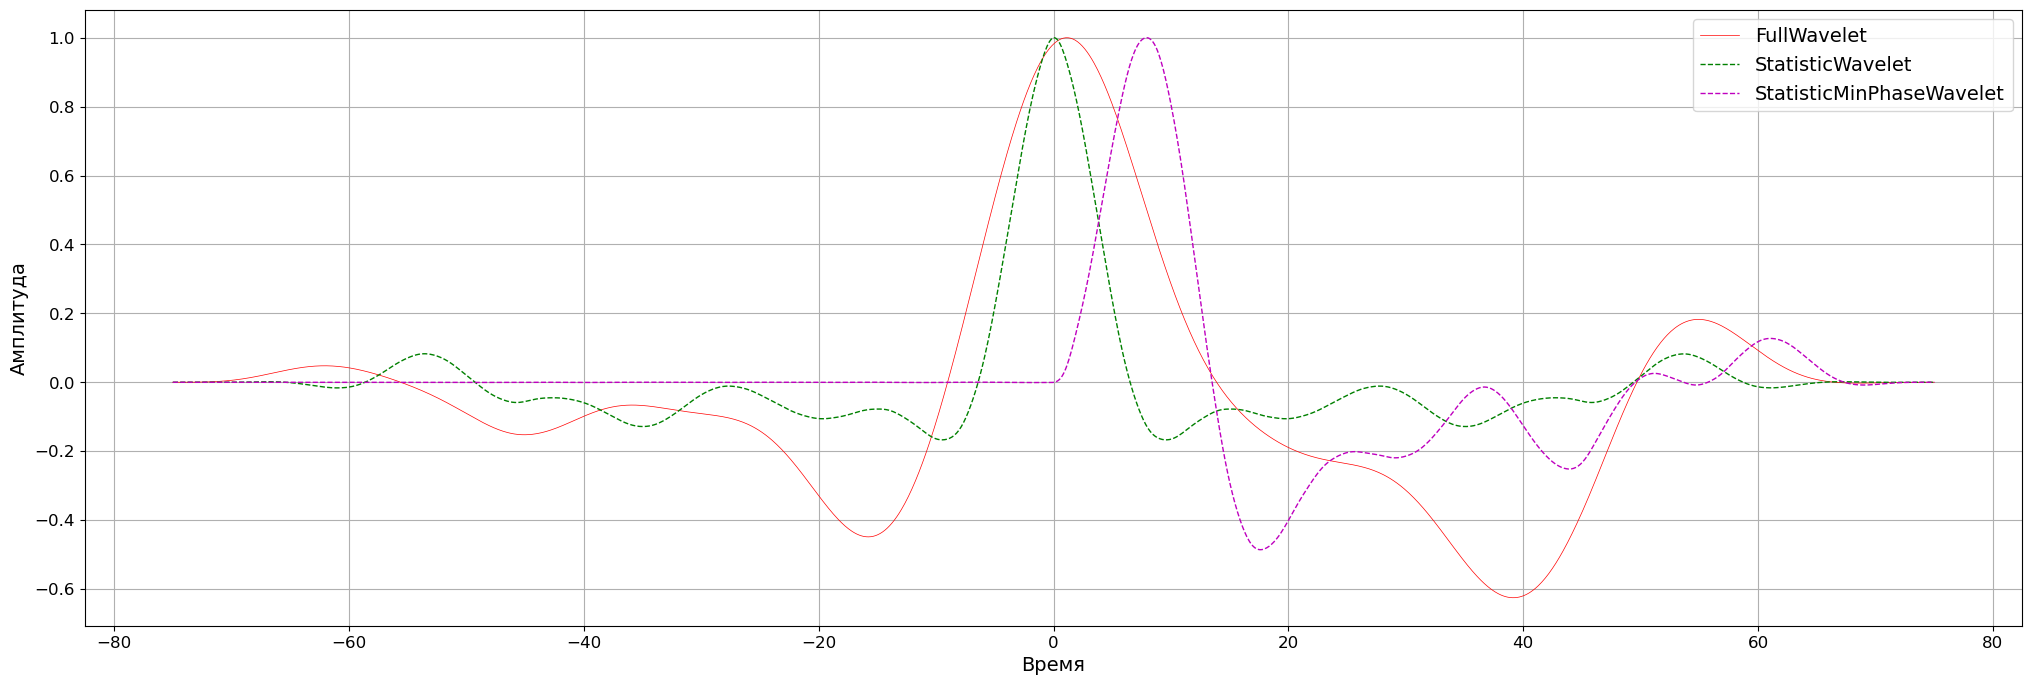

In [201]:
Trace = trace_int.copy()
Rpp = Rpp_boundary.copy()
T = T_well.copy()
dt = dt_well


TCut = np.arange(0.6, 1.4, dt)
WaveletLength = 150
SigmaAutocor = 10

Taper = 30

# TraceCut = IntervalData (Trace, T, TCut, dt)


TimeShiftStatistic = 0

StatisticMinPhaseWavelet, TimeWavelet_1 = StatisticMinPhaseMethod (Trace, T, TCut, dt, WaveletLength, SigmaAutocor, alpha = 0.0, Taper = Taper)
StatisticWavelet, TimeWavelet_1 = StatisticMethod (Trace, T, TCut, dt, WaveletLength, SigmaAutocor, alpha = 0.0, Taper = Taper)
FullWavelet, TimeWavelet_2 = FullWaveletMethod (Trace, Rpp, T, TCut, WaveletLength, dt, SigmaAutocor = 40, alpha = 0.2, Taper = 30)

StatisticMinPhaseWavelet = ShiftData (StatisticMinPhaseWavelet, TimeShiftStatistic, dt)


norm = 1

plt.figure(figsize = (25, 8))
if norm == 1:
    plt.plot(TimeWavelet_1, FullWavelet/np.max(FullWavelet), 'r', lw = 0.5, label = 'FullWavelet')
    plt.plot(TimeWavelet_1, StatisticWavelet/np.max(StatisticWavelet), '--g', lw = 1, label = 'StatisticWavelet')
    plt.plot(TimeWavelet_1, StatisticMinPhaseWavelet/np.max(StatisticMinPhaseWavelet), '--m', lw = 1, label = 'StatisticMinPhaseWavelet')
else:
    plt.plot(TimeWavelet_1, FullWavelet, 'r', lw = 0.5, label = 'FullWavelet')
    plt.plot(TimeWavelet_1, StatisticWavelet, '--g', lw = 1, label = 'StatisticWavelet')
    plt.plot(TimeWavelet_1, StatisticMinPhaseWavelet, '--m', lw = 1, label = 'StatisticMinPhaseWavelet')

plt.legend(fontsize = 14)
plt.grid(':')
plt.xlabel('Время', fontsize = 14)
plt.ylabel('Амплитуда', fontsize =14)

Text(0, 0.5, 'Амплитуда')

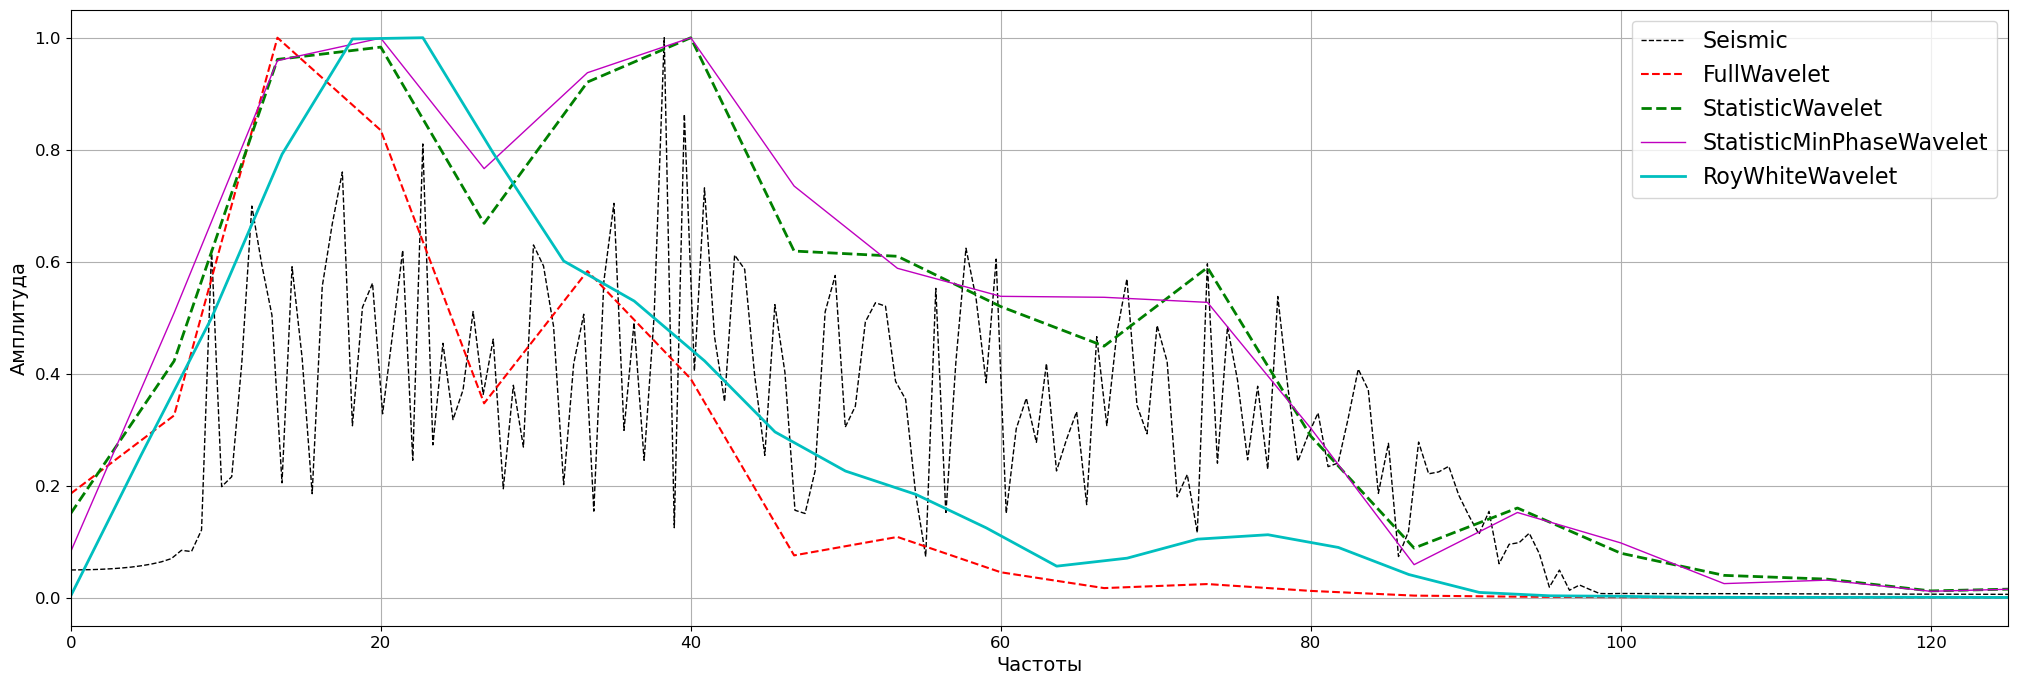

In [202]:
FreqTrace, AmpTrace = FFT(Trace, dt)#; AmpTrace, FreqTrace = AmpTrace, FreqTrace
FreqFullWavelet, AmpFullWavelet = FFT(FullWavelet, dt)
FreqStatisticWavelet, AmpStatisticWavelet = FFT(StatisticWavelet, dt)
FreqStatisticMinPhaseWavelet, AmpStatisticMinPhaseWavelet = FFT(StatisticMinPhaseWavelet, dt)
FreqRoyWhiteWavelet, AmpRoyWhiteWavelet = FFT(RoyWhiteWavelet_, dt)


norm = 1

plt.figure(figsize = (25, 8))
if norm == 1:
    plt.plot(FreqTrace, AmpTrace/np.max(AmpTrace), '--k', lw = 1, label = 'Seismic')
    plt.plot(FreqFullWavelet, AmpFullWavelet/np.max(AmpFullWavelet), '--r', lw = 1.5, label = 'FullWavelet')
    plt.plot(FreqStatisticWavelet, AmpStatisticWavelet/np.max(AmpStatisticWavelet), '--g', lw = 2, label = 'StatisticWavelet')
    
    plt.plot(FreqStatisticMinPhaseWavelet, AmpStatisticMinPhaseWavelet/np.max(AmpStatisticMinPhaseWavelet), '-m', lw = 1, label = 'StatisticMinPhaseWavelet')
    plt.plot(FreqRoyWhiteWavelet, AmpRoyWhiteWavelet/np.max(AmpRoyWhiteWavelet), '-', color = 'c', lw = 2, label = 'RoyWhiteWavelet')
else:
    plt.plot(FreqTrace, AmpTrace, '--k', lw = 1, label = 'Seismic')
    plt.plot(FreqFullWavelet, AmpFullWavelet, '--r', lw = 1.5, label = 'FullWavelet')
    plt.plot(FreqStatisticWavelet, AmpStatisticWavelet, '--g', lw = 2, label = 'StatisticWavelet')

    plt.plot(FreqStatisticMinPhaseWavelet, AmpStatisticMinPhaseWavelet, '-m', lw = 1, label = 'StatisticMinPhaseWavelet')
    plt.plot(FreqRoyWhiteWavelet, AmpRoyWhiteWavelet, '-', color = 'c', lw = 2, label = 'RoyWhiteWavelet')

plt.legend(fontsize = 16)
plt.grid(':')
plt.xlim(0, 125)
plt.xlabel('Частоты', fontsize = 14)
plt.ylabel('Амплитуда', fontsize =14)

In [203]:
# imp = StatisticWavelet # FullWavelet   StatisticWavelet     
# refl_int = Rpp_boundary

# n = 360
# angle = np.linspace(-180, 180, n+1)
# phases = angle * np.pi/180

# # phases = np.linspace(-np.pi, np.pi, n+1)

# WaveletPhase, DataSet = teor_sig_with_phases(imp, dt, phases, refl_int)

# TracePlot = Trace/np.max(np.abs(Trace))
# corr = []

# for i in range(DataSet.shape[0]):
#     T_kk = np.arange(0.6, 1.4, dt)
#     TraceSyntPlot = DataSet[i]#/np.max(np.abs(DataSet[i]))
#     kk_cut_0 = kk_cut_T(TracePlot,TraceSyntPlot, dt, T_kk)

#     corr.append(kk_cut_0)

# plt.plot(phases, corr)
# plt.title(f'Max correlation = {corr[np.argmax(corr)]}\nAngle = {angle[np.argmax(corr)]}')

In [204]:
# lb_size = 12
# plt.figure(figsize = (15, 8))
# plt.rc('ytick', labelsize= lb_size)
# plt.rc('xtick', labelsize= lb_size)

# norm = 0
# if norm == 1:
#     plt.plot(TimeWavelet_1, StatisticWavelet/np.max(StatisticWavelet), '--m', lw = 1, label = f'StatisticWavelet') 
#     plt.plot(TimeWavelet_1, WaveletPhase[np.argmax(corr)]/np.max(WaveletPhase[np.argmax(corr)]), '--', color = 'aqua', lw = 1.5, label = f'StatisticWaveletPhase') 
#     plt.plot(TimeWavelet_2, FullWavelet/np.max(FullWavelet), 'r', lw = 0.5, label = 'FullWavelet')
# else:
#     plt.plot(TimeWavelet_1, StatisticWavelet, '--m', lw = 1, label = f'StatisticWavelet') 
#     plt.plot(TimeWavelet_1, WaveletPhase[np.argmax(corr)], '--', color = 'c', lw = 1.5, label = f'StatisticWaveletPhase') 
#     plt.plot(TimeWavelet_2, FullWavelet, 'r', lw = 0.5, label = 'FullWavelet')
# plt.grid()

FullWavelet -  0.675
StatisticWavelet -  0.551
StatisticMinPhaseWavelet -  0.234
RoyWhiteWavelet Var1-  0.547
RoyWhiteWavelet Var2-  0.648

FullWavelet and RoyWhiteWavelet Var1-  0.831
FullWavelet and RoyWhiteWavelet Var2-  0.929


(0.6, 1.3998999999999118)

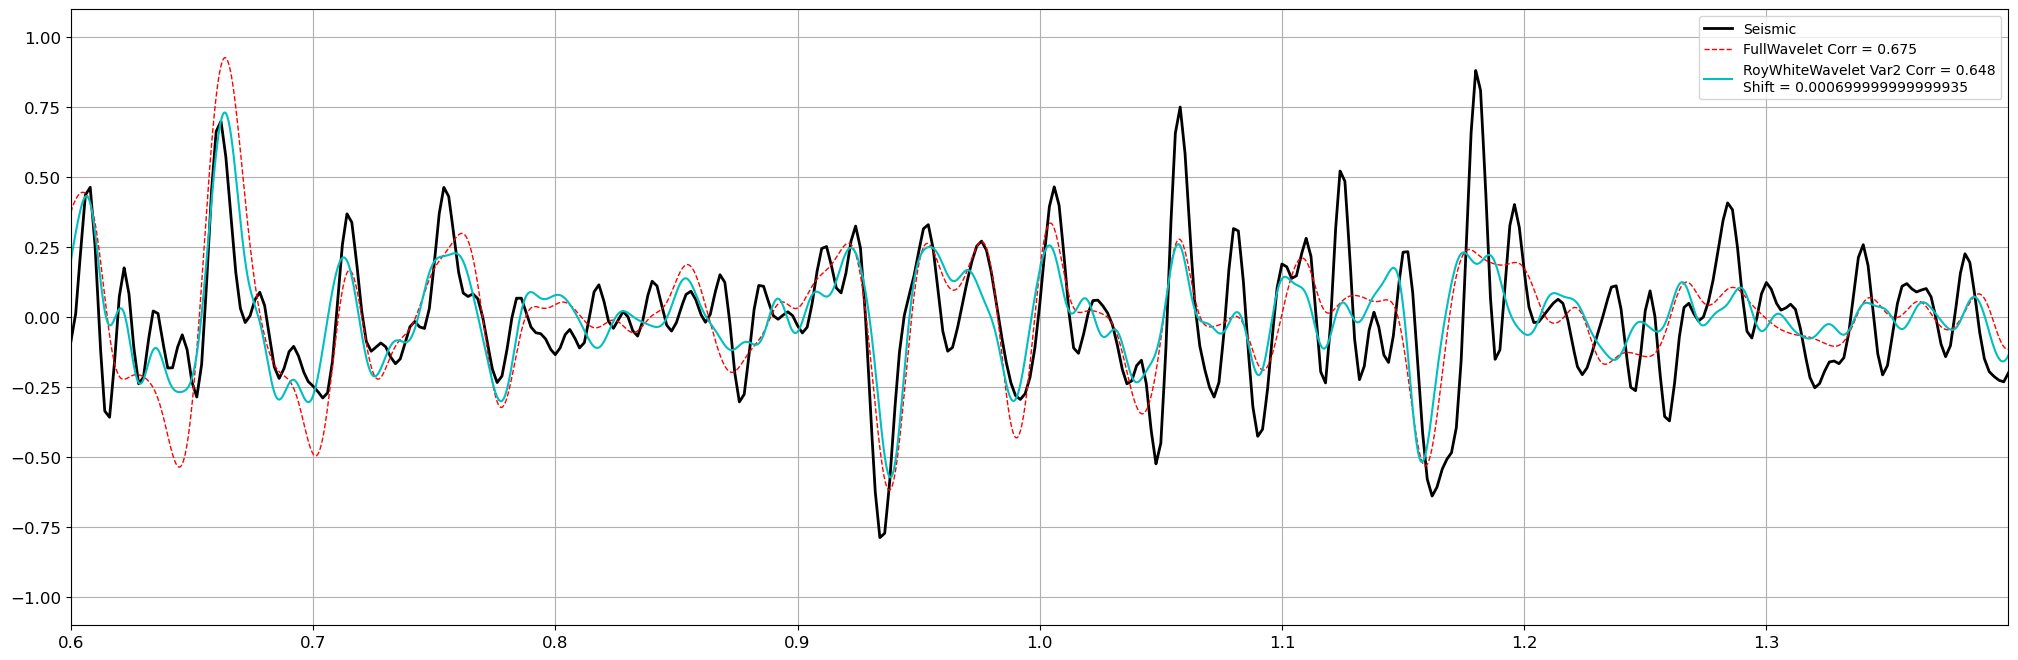

In [205]:



TraceSynt_1 = np.convolve(FullWavelet, Rpp, mode = 'same')
TraceSynt_2 = np.convolve(StatisticWavelet, Rpp, mode = 'same')
TraceSynt_3 = np.convolve(StatisticMinPhaseWavelet, Rpp, mode = 'same')
TraceSynt_4 = np.convolve(RoyWhiteWavelet, Rpp, mode = 'same')
TraceSynt_5 = np.convolve(RoyWhiteWavelet_, Rpp, mode = 'same')

T_kk = np.arange(.6, 1.4, dt)

TracePlot = Trace

kk_cut_1 = kk_cut_T(TracePlot, TraceSynt_1, dt, T_kk)
kk_cut_2 = kk_cut_T(TracePlot, TraceSynt_2, dt, T_kk)
kk_cut_3 = kk_cut_T(TracePlot, TraceSynt_3, dt, T_kk)
kk_cut_4 = kk_cut_T(TracePlot, TraceSynt_4, dt, T_kk)
kk_cut_5 = kk_cut_T(TracePlot, TraceSynt_5, dt, T_kk)

kk_cut_6 = kk_cut_T(TraceSynt_1, TraceSynt_4, dt, T_kk)
kk_cut_7 = kk_cut_T(TraceSynt_1, TraceSynt_5, dt, T_kk)
print('FullWavelet - ', kk_cut_1)
print('StatisticWavelet - ', kk_cut_2)
print('StatisticMinPhaseWavelet - ', kk_cut_3)
print('RoyWhiteWavelet Var1- ', kk_cut_4)
print('RoyWhiteWavelet Var2- ', kk_cut_5)
print('')
print('FullWavelet and RoyWhiteWavelet Var1- ', kk_cut_6)
print('FullWavelet and RoyWhiteWavelet Var2- ', kk_cut_7)

lb_size = 12
plt.figure(figsize = (25, 8))
plt.rc('ytick', labelsize= lb_size)
plt.rc('xtick', labelsize= lb_size)

norm = 1

if norm == 1:
    plt.plot(T,TracePlot/np.max(np.abs(TracePlot)), 'k', lw = 2, label = 'Seismic')

    plt.plot(T,TraceSynt_1/np.max(np.abs(TraceSynt_1)), '--r', lw = 1, label = f'FullWavelet Corr = {kk_cut_1}')
    # plt.plot(T,TraceSynt_2/np.max(np.abs(TraceSynt_2)), '--g', lw = 2, label = f'StatisticWavelet Corr = {kk_cut_2}') 
    # plt.plot(T,TraceSynt_3/np.max(np.abs(TraceSynt_3)), '--m', lw = 1.5, label = f'StatisticMinPhaseWavelet Corr = {kk_cut_3}') 
    # plt.plot(T,TraceSynt_4/np.max(np.abs(TraceSynt_4)), '-', color = 'c', lw = 1.5, label = f'RoyWhiteWavelet Var1 Corr = {kk_cut_4}\nShift = {TimeShift}') 
    plt.plot(T,TraceSynt_5/np.max(np.abs(TraceSynt_5)), '-', color = 'c', lw = 1.5, label = f'RoyWhiteWavelet Var2 Corr = {kk_cut_5}\nShift = {TimeShift_}') 
else:
    plt.plot(T,TracePlot, 'k', lw = 2, label = 'Seismic')

    plt.plot(T,TraceSynt_1, '--r', lw = 1, label = f'FullWavelet Corr = {kk_cut_1}')
    # plt.plot(T,TraceSynt_2, '--g', lw = 2, label = f'StatisticWavelet Corr = {kk_cut_2}') 
    # plt.plot(T,TraceSynt_3, '--m', lw = 1.5, label = f'StatisticMinPhaseWavelet Corr = {kk_cut_3}') 
    # plt.plot(T,TraceSynt_4, '-', color = 'c', lw = 1.5, label = f'RoyWhiteWavelet Corr = {kk_cut_4}\nShift = {TimeShift}') 
    plt.plot(T,TraceSynt_5, '-', color = 'c', lw = 1.5, label = f'RoyWhiteWavelet Corr = {kk_cut_5}\nShift = {TimeShift_}') 


plt.legend()
plt.grid()
plt.xlim(np.min(T_kk), np.max(T_kk))

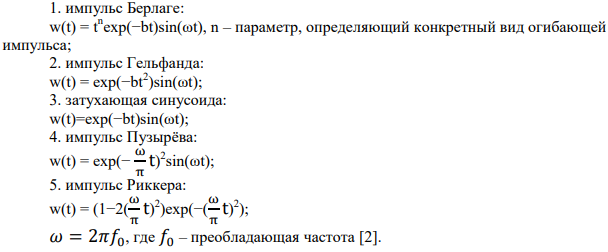


In [206]:
def ImpulseRikker (f0, T):


    # f0 = f0 * 10
    w = 2 * np.pi * f0

    Wavelet = (1 - 2 * ( w / np.pi * T) ** 2) * np.exp(-( w / np.pi * T) ** 2)

    return Wavelet 

def ImpulsePuzyrev (f0, T):

    f0 = f0 
    w = 2 * np.pi * f0

    Wavelet = np.exp(- w / np.pi * T) ** 2 * np.sin(w * T)

    return Wavelet


def Gauss(fc, dt: float):

    '''
    Функция создания импульса формы первой производной Гаусса

    Параметры
    --------------
    Вход:
        fc - Частота сигнала
        dt - Шаг по времения (дискретизация)
        

    Выход:
        impuls  - Значения импульса с шагом dt (NDArray[float64])
        time_new - Регулярная сетка времен для импульса с шагом dt (NDArray[float64])
    '''    

    T = 1
    dt_impuls = dt
    time = np.arange(0, T, dt_impuls)
    

    a = np.pi ** 2 * fc ** 2
    ts = 1.2 / fc

    index_cut = int((ts * 2)/dt_impuls + 1)
    time_new = time[ :index_cut ]

    TimeAdd = np.sort(-time_new)
    TimeWavelet = np.insert(time_new, 0, TimeAdd)

    impuls_gauss = np.exp(-a * (time_new - ts) ** 2)
    impuls = impuls_gauss / np.max(np.abs(impuls_gauss))

    ''' СГЛАЖИВАНИЕ НА КРАЯХ '''
    window = signal.windows.tukey(len(time_new), alpha=0.5)
    impuls = impuls * window

    WaveletAdd = np.zeros((len(time_new)))
    Wavelet = np.insert(impuls, 0, WaveletAdd)
    
    return Wavelet, TimeWavelet


def first_derivative_of_Gauss(fc, dt: float):

    '''
    Функция создания импульса формы первой производной Гаусса

    Параметры
    --------------
    Вход:
        fc - Частота сигнала
        dt - Шаг по времения (дискретизация)
        

    Выход:
        impuls  - Значения импульса с шагом dt (NDArray[float64])
        time_new - Регулярная сетка времен для импульса с шагом dt (NDArray[float64])
    '''    

    T = 1
    dt_impuls = dt
    time = np.arange(0, T, dt_impuls)
    

    a = np.pi ** 2 * fc ** 2
    ts = 1.2 / fc

    index_cut = int((ts * 2)/dt_impuls + 1)
    time_new = time[ :index_cut ]

    TimeAdd = np.sort(-time_new)
    TimeWavelet = np.insert(time_new, 0, TimeAdd)

    impuls_gauss = -2 * a * (time_new - ts) * np.exp(-a * (time_new - ts) ** 2)
    impuls = impuls_gauss / np.max(np.abs(impuls_gauss))

    ''' СГЛАЖИВАНИЕ НА КРАЯХ '''
    window = signal.windows.tukey(len(time_new), alpha=0.5)
    impuls = impuls * window

    WaveletAdd = np.zeros((len(time_new)))
    Wavelet = np.insert(impuls, 0, WaveletAdd)

    
    return Wavelet, TimeWavelet



def second_derivative_of_Gauss(fc, dt: float):

    '''
    Функция создания импульса формы первой производной Гаусса

    Параметры
    --------------
    Вход:
        fc - Частота сигнала
        dt - Шаг по времения (дискретизация)
        

    Выход:
        impuls  - Значения импульса с шагом dt (NDArray[float64])
        time_new - Вектор времен для импульса с шагом dt (NDArray[float64])
    '''    

    T = 1
    dt_impuls = dt
    time = np.arange(0, T, dt_impuls)
    

    a = np.pi ** 2 * fc ** 2
    ts = 1.2 / fc

    index_cut = int((ts * 2)/dt_impuls + 1)
    time_new = time[ :index_cut ]

    TimeAdd = np.sort(-time_new)
    TimeWavelet = np.insert(time_new, 0, TimeAdd)

    impuls_gauss = -4 * a * (time_new - ts) * (a * (time_new - ts) ** 2 - 1) * np.exp(-a * (time_new - ts) ** 2)
    
    impuls = impuls_gauss / np.max(np.abs(impuls_gauss))

    WaveletAdd = np.zeros((len(time_new)))
    Wavelet = np.insert(impuls, 0, WaveletAdd)

    
    return Wavelet, TimeWavelet

In [207]:
dt = 1e-4
T_synt = np.arange(0,1,dt)

In [208]:
vp = np.ones((T_synt.shape[0])) * 2200
# vp[:int(0.200/dt)] = 1400; vp[int(0.200/dt):int(0.400/dt)] = 1600; vp[int(0.400/dt):int(0.600/dt)] = 1800; vp[int(0.600/dt):int(0.800/dt)] = 2000

vp[:int(0.200/dt)] = 1400; vp[int(0.300/dt):int(0.400/dt)] = 1600; vp[int(0.500/dt):int(0.600/dt)] = 1800; vp[int(0.700/dt):int(0.800/dt)] = 2000
vp[int(0.200/dt):int(0.300/dt)] = 1500; vp[int(0.400/dt):int(0.500/dt)] = 1700; vp[int(0.600/dt):int(0.700/dt)] = 1900; vp[int(0.800/dt):int(0.900/dt)] = 2100

rho = np.ones((T_synt.shape[0])) * 3
# rho[:int(0.200/dt)] = 2; rho[int(0.200/dt):int(0.400/dt)] = 2.2; rho[int(0.400/dh):int(0.600/dt)] = 2.4; rho[int(0.600/dt):int(0.800/dt)] = 2.6

rho[:int(0.200/dt)] = 2; rho[int(0.200/dt):int(0.300/dt)] = 2.1
rho[int(0.300/dt):int(0.400/dt)] = 2.2; rho[int(0.400/dt):int(0.500/dt)] = 2.3
rho[int(0.500/dt):int(0.600/dt)] = 2.4; rho[int(0.600/dt):int(0.700/dt)] = 2.5
rho[int(0.700/dt):int(0.800/dt)] = 2.6; rho[int(0.800/dt):int(0.900/dt)] = 2.7

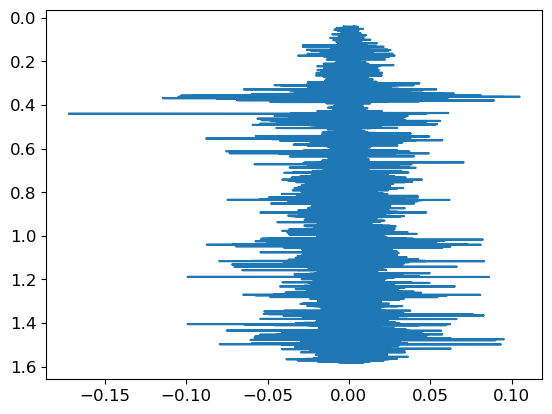

In [209]:
Rpp_sunt_new = reflection_coef(vp, rho)


T_synt = np.arange(np.min(T_well),np.max(T_well),dt)
Rpp_sunt_new = np.interp(T_synt,T_well,Rpp_boundary)

plt.plot(Rpp_sunt_new, T_synt)
plt.gca().invert_yaxis()

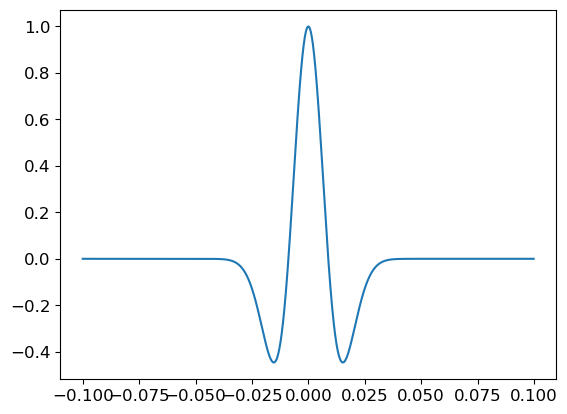

In [210]:
WaveletLength = 200
DT = dt*10
TimeWavelet = np.arange(-WaveletLength / 2 * DT, WaveletLength / 2 * DT, dt)
f0 = 40
# Wavelet, TimeWavelet = first_derivative_of_Gauss (f0, dt) # Gauss(fc, dt: float)    first_derivative_of_Gauss(fc, dt: float) second_derivative_of_Gauss(fc, dt: float)
Wavelet = ImpulseRikker (f0, TimeWavelet)
plt.plot(TimeWavelet, Wavelet)

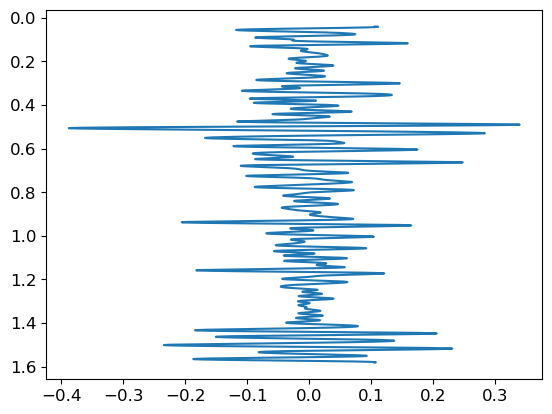

In [211]:
TraceSynt = np.convolve(Wavelet, Rpp_sunt_new, mode = 'same')

plt.plot(TraceSynt, T_synt)
plt.gca().invert_yaxis()

In [272]:
# import random


# Trace = TraceSynt.copy()
# Rpp = Rpp_sunt_new.copy()
# T = T_synt.copy()


# coefTrace = 10
# RangeNoiseTrace = np.linspace(-np.abs(np.mean(Trace)) * coef, np.abs(np.mean(Trace))* coef, 100)
# NoiseTrace = np.ones((len(Trace)))
# for i in range(len(Trace)):
#     NoiseTrace[i] *= random.choice(RangeNoiseTrace)



# coefRpp = 10
# RangeNoiseRpp = np.linspace(-np.abs(np.mean(Rpp)) * coef, np.abs(np.mean(Rpp))* coef, 100)
# NoiseRpp = np.ones((len(Rpp)))
# for i in range(len(Rpp)):
#     NoiseRpp[i] *= random.choice(RangeNoiseRpp)


# Rpp += NoiseRpp
# Trace += NoiseTrace

# plt.figure(figsize=(25, 7))
# plt.subplot(1,2,1)
# plt.plot(Trace)
# plt.plot(TraceSynt)

# plt.subplot(1,2,2)
# plt.plot(Rpp)
# plt.plot(Rpp_sunt_new)

Text(0, 0.5, 'Амплитуда')

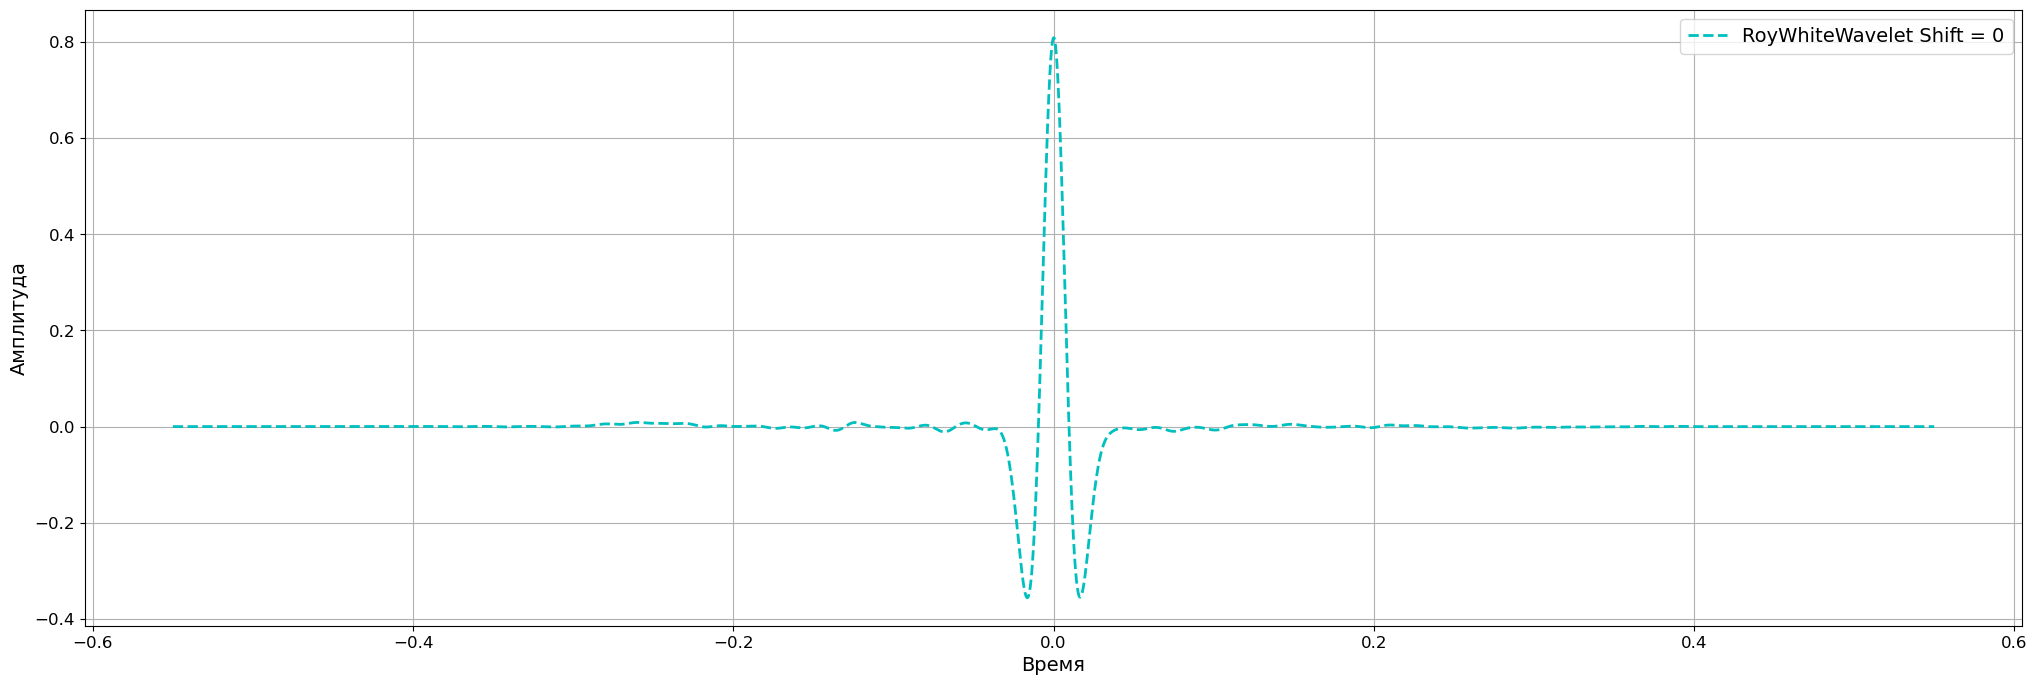

In [281]:
Trace = TraceSynt.copy()
Rpp = Rpp_sunt_new.copy()
T = T_synt.copy()


dt = dt_well
TCut = np.arange(.4, 1.5, dt)
WaveletLength = 200
SigmaAutocor = 35
Shift = 0

Taper = 0

RoyWhiteWavelet, TimeWavelet_3, TimeShift = RoyWhiteMethod_ (Trace, T, TCut, dt, Rpp, Shift, SigmaAutocor, alpha = 1, Taper = Taper, Stab = 1e-6)

RoyWhiteWavelet = ShiftData (RoyWhiteWavelet, TimeShift * 1000, dt)




norm = 0

plt.figure(figsize = (25, 8))
if norm == 1:
    plt.plot(TimeWavelet_3, RoyWhiteWavelet/np.max(RoyWhiteWavelet), '-', color = 'c', lw = 2, label = f'RoyWhiteWavelet Shift = {TimeShift}')
else:
    plt.plot(TimeWavelet_3, RoyWhiteWavelet, '--', color = 'c', lw = 2, label = f'RoyWhiteWavelet Shift = {TimeShift}')

plt.legend(fontsize = 14)
plt.grid(':')
plt.xlabel('Время', fontsize = 14)
plt.ylabel('Амплитуда', fontsize =14)

Text(0, 0.5, 'Амплитуда')

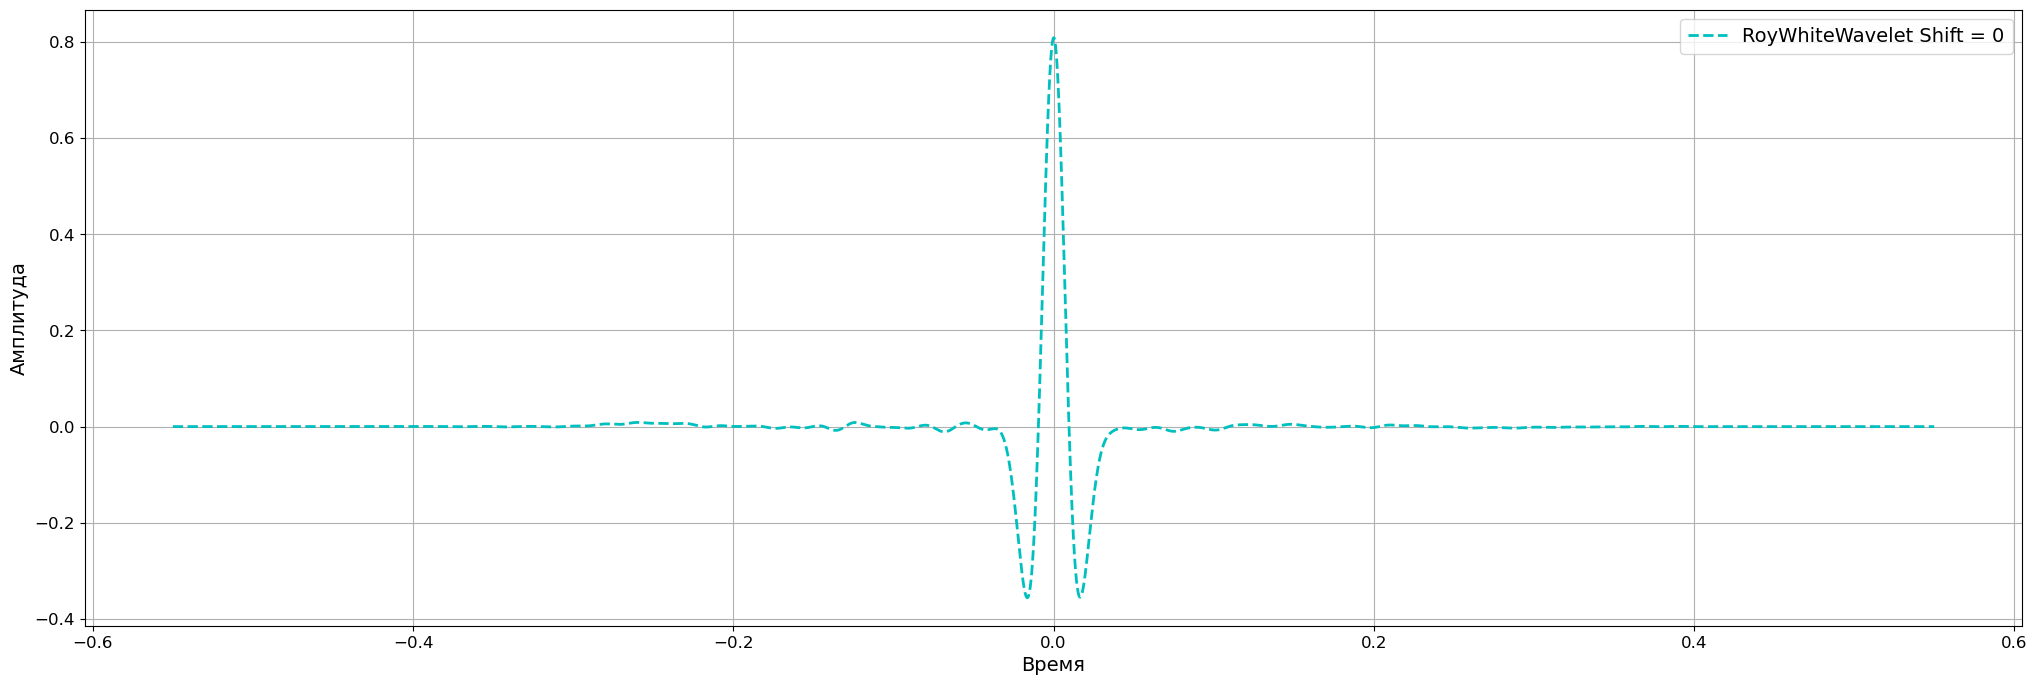

In [282]:
# Trace = TraceSynt.copy()
# Rpp = Rpp_sunt_new.copy()
# T = T_synt.copy()


dt = dt_well
# TCut = np.arange(.6, 0.8, dt)
WaveletLength = 200
SigmaAutocor = 35
Shift = 0

Taper = 0

RoyWhiteWavelet, TimeWavelet_3, TimeShift = RoyWhiteMethod (Trace, T, TCut, dt, Rpp, Shift, SigmaAutocor, dShift = 1, Stab = 1e-6, alpha = 1, Taper = Taper )


RoyWhiteWavelet = ShiftData (RoyWhiteWavelet, TimeShift * 1000, dt)


norm = 0

plt.figure(figsize = (25, 8))
if norm == 1:
    plt.plot(TimeWavelet_3, RoyWhiteWavelet/np.max(RoyWhiteWavelet), '-', color = 'c', lw = 2, label = f'RoyWhiteWavelet Shift = {TimeShift}')
else:
    plt.plot(TimeWavelet_3, RoyWhiteWavelet, '--', color = 'c', lw = 2, label = f'RoyWhiteWavelet Shift = {TimeShift}')

plt.legend(fontsize = 14)
plt.grid(':')
plt.xlabel('Время', fontsize = 14)
plt.ylabel('Амплитуда', fontsize =14)

Text(0, 0.5, 'Амплитуда')

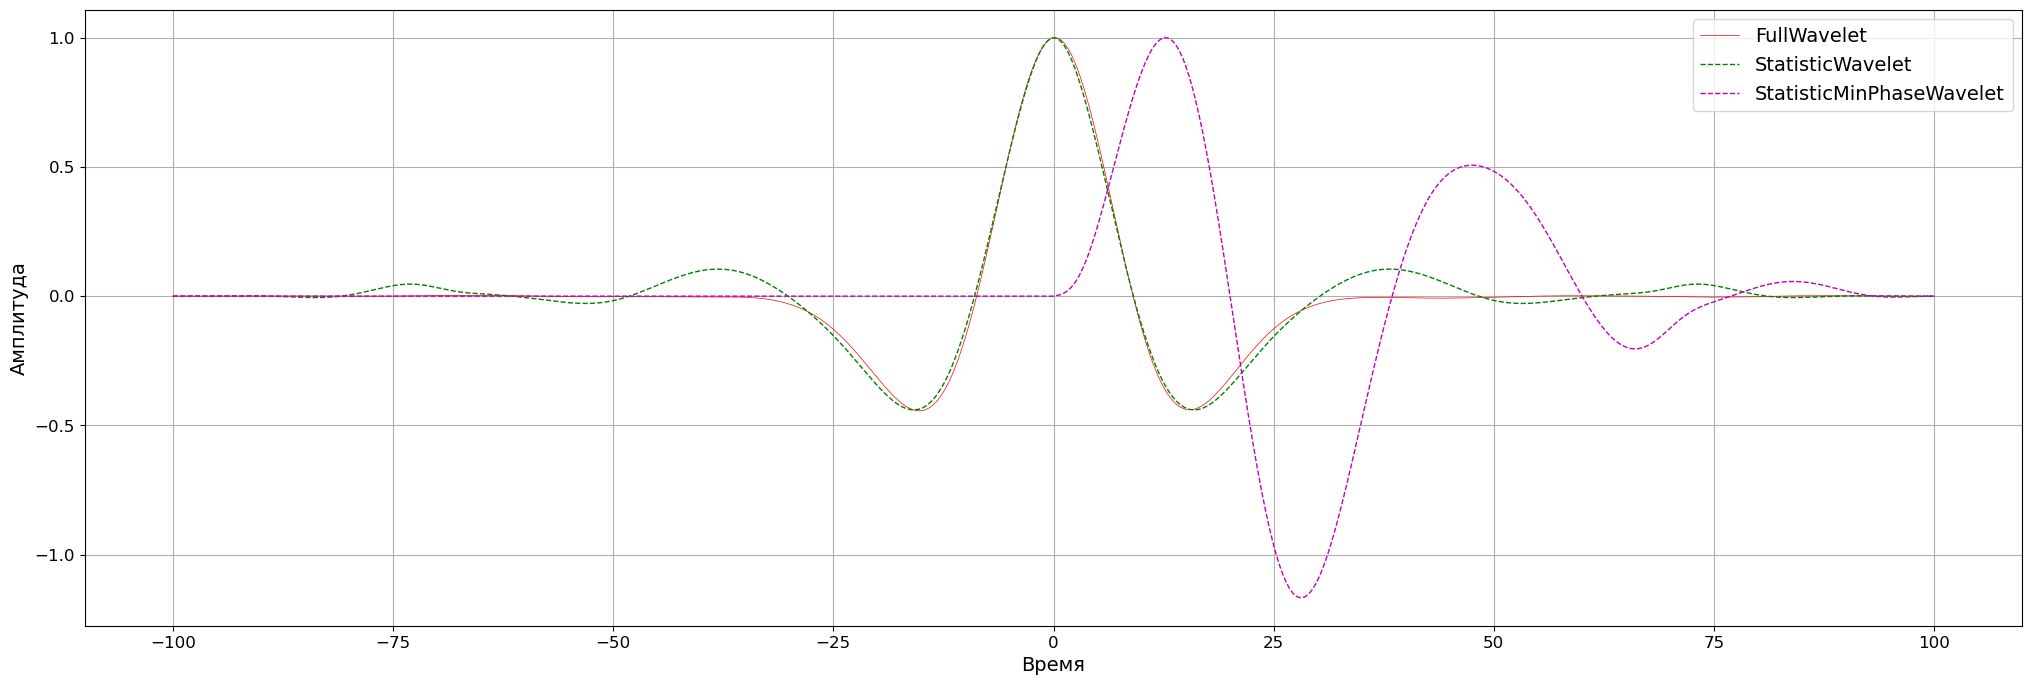

In [275]:
# Trace = TraceSynt.copy()
# Rpp = Rpp_sunt_new.copy()
# T = T_synt.copy()


dt = dt_well
TCut = T #np.arange(0., 1., dt)
WaveletLength = 200
SigmaAutocor = 30

Taper = 30

TimeShift = 0

StatisticMinPhaseWavelet, TimeWavelet_1 = StatisticMinPhaseMethod (Trace, T, TCut, dt, WaveletLength, SigmaAutocor, alpha = 0.0, Taper = Taper)
StatisticWavelet, TimeWavelet_1 = StatisticMethod (Trace, T, TCut, dt, WaveletLength, SigmaAutocor, alpha = 1.0, Taper = Taper)
FullWavelet, TimeWavelet_2 = FullWaveletMethod (Trace, Rpp, T, TCut, WaveletLength, dt, SigmaAutocor = 5, alpha = 0.2, Taper = 30)

StatisticMinPhaseWavelet = ShiftData (StatisticMinPhaseWavelet, TimeShift, dt)


norm = 1

plt.figure(figsize = (25, 8))
if norm == 1:
    plt.plot(TimeWavelet_1, FullWavelet/np.max(FullWavelet), 'r', lw = 0.5, label = 'FullWavelet')
    plt.plot(TimeWavelet_1, StatisticWavelet/np.max(StatisticWavelet), '--g', lw = 1, label = 'StatisticWavelet')
    plt.plot(TimeWavelet_1, StatisticMinPhaseWavelet/np.max(StatisticMinPhaseWavelet), '--m', lw = 1, label = 'StatisticMinPhaseWavelet')
else:
    plt.plot(TimeWavelet_1, FullWavelet, 'r', lw = 0.5, label = 'FullWavelet')
    plt.plot(TimeWavelet_1, StatisticWavelet, '--g', lw = 1, label = 'StatisticWavelet')
    plt.plot(TimeWavelet_1, StatisticMinPhaseWavelet, '--m', lw = 1, label = 'StatisticMinPhaseWavelet')

plt.legend(fontsize = 14)
plt.grid(':')
plt.xlabel('Время', fontsize = 14)
plt.ylabel('Амплитуда', fontsize =14)

Text(0, 0.5, 'Амплитуда')

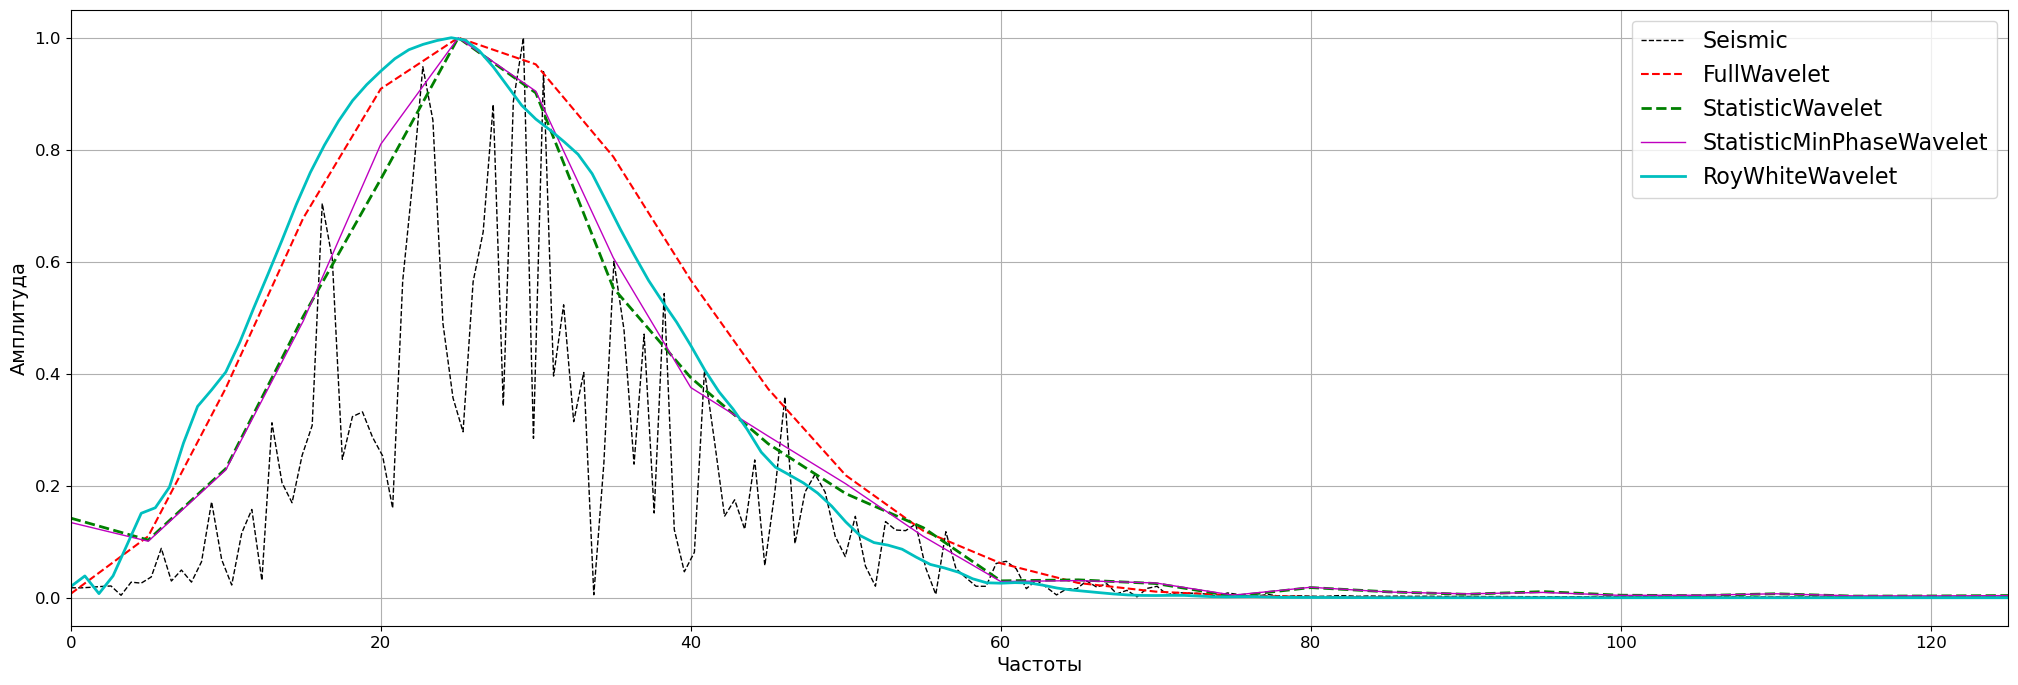

In [283]:
FreqTrace, AmpTrace = FFT(Trace, dt)#; AmpTrace, FreqTrace = AmpTrace, FreqTrace
FreqFullWavelet, AmpFullWavelet = FFT(FullWavelet, dt)
FreqStatisticWavelet, AmpStatisticWavelet = FFT(StatisticWavelet, dt)
FreqStatisticMinPhaseWavelet, AmpStatisticMinPhaseWavelet = FFT(StatisticMinPhaseWavelet, dt)
FreqRoyWhiteWavelet, AmpRoyWhiteWavelet = FFT(RoyWhiteWavelet, dt)


norm = 1

plt.figure(figsize = (25, 8))
if norm == 1:
    plt.plot(FreqTrace, AmpTrace/np.max(AmpTrace), '--k', lw = 1, label = 'Seismic')
    plt.plot(FreqFullWavelet, AmpFullWavelet/np.max(AmpFullWavelet), '--r', lw = 1.5, label = 'FullWavelet')
    plt.plot(FreqStatisticWavelet, AmpStatisticWavelet/np.max(AmpStatisticWavelet), '--g', lw = 2, label = 'StatisticWavelet')
    
    plt.plot(FreqStatisticMinPhaseWavelet, AmpStatisticMinPhaseWavelet/np.max(AmpStatisticMinPhaseWavelet), '-m', lw = 1, label = 'StatisticMinPhaseWavelet')
    plt.plot(FreqRoyWhiteWavelet, AmpRoyWhiteWavelet/np.max(AmpRoyWhiteWavelet), '-', color = 'c', lw = 2, label = 'RoyWhiteWavelet')
else:
    plt.plot(FreqTrace, AmpTrace, '--k', lw = 1, label = 'Seismic')
    plt.plot(FreqFullWavelet, AmpFullWavelet, '--r', lw = 1.5, label = 'FullWavelet')
    plt.plot(FreqStatisticWavelet, AmpStatisticWavelet, '--g', lw = 2, label = 'StatisticWavelet')

    plt.plot(FreqStatisticMinPhaseWavelet, AmpStatisticMinPhaseWavelet, '-m', lw = 1, label = 'StatisticMinPhaseWavelet')
    plt.plot(FreqRoyWhiteWavelet, AmpRoyWhiteWavelet, '-', color = 'c', lw = 2, label = 'RoyWhiteWavelet')

plt.legend(fontsize = 16)
plt.grid(':')
plt.xlim(0, 125)
plt.xlabel('Частоты', fontsize = 14)
plt.ylabel('Амплитуда', fontsize =14)

FullWavelet -  1.0
StatisticWavelet -  0.989
StatisticMinPhaseWavelet -  -0.001
RoyWhiteWavelet Var1-  0.992
RoyWhiteWavelet Var2-  0.891

FullWavelet and RoyWhiteWavelet Var1-  0.992
FullWavelet and RoyWhiteWavelet Var2-  0.895


(0.6, 1.3998999999999118)

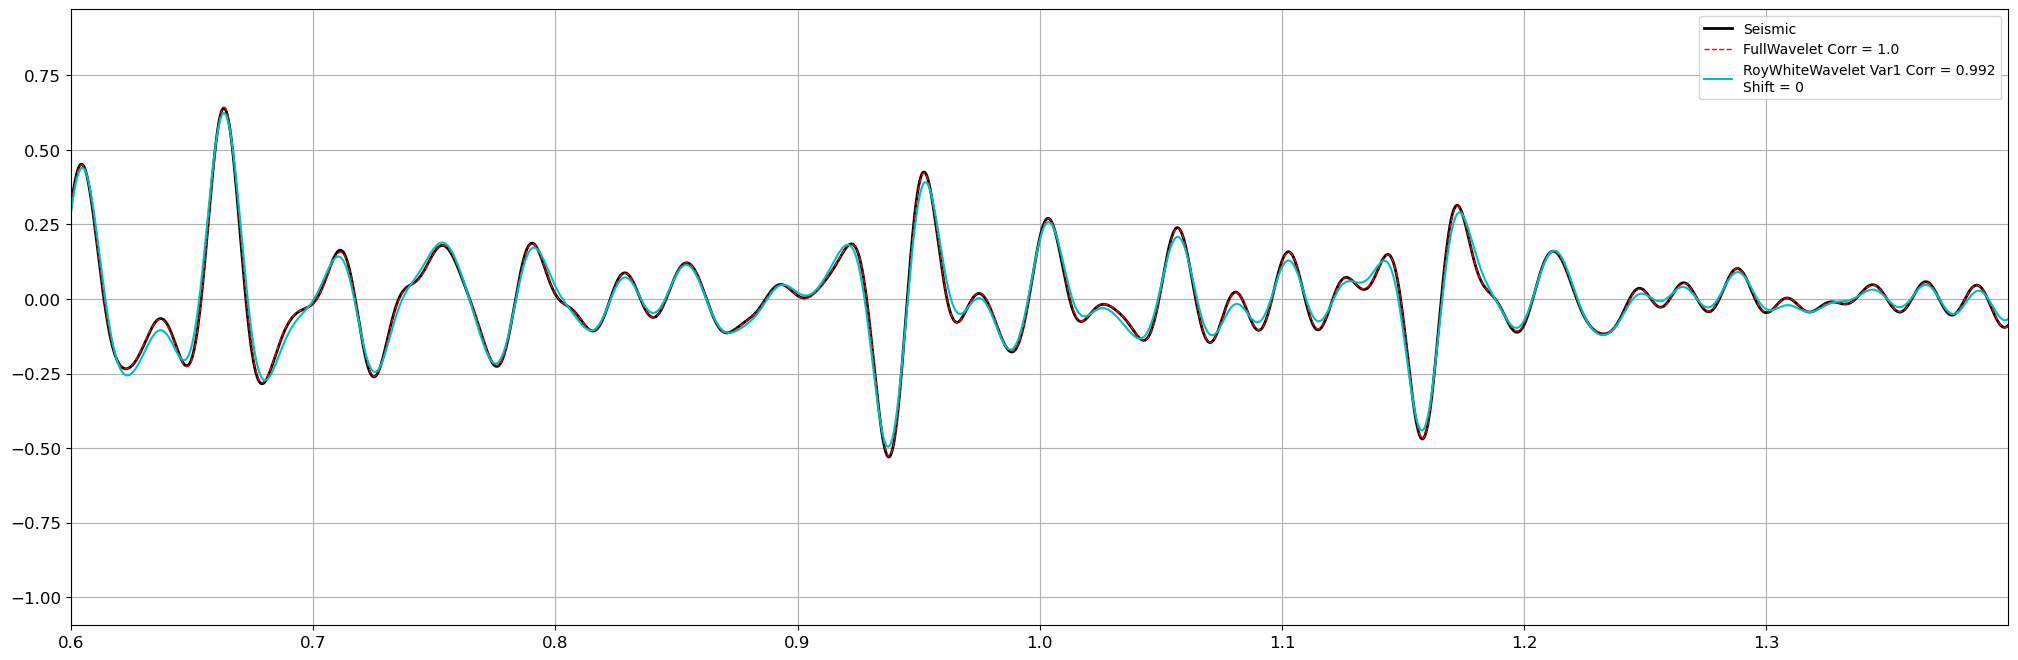

In [284]:
TraceSynt_1 = np.convolve(FullWavelet, Rpp, mode = 'same')
TraceSynt_2 = np.convolve(StatisticWavelet, Rpp, mode = 'same')
TraceSynt_3 = np.convolve(StatisticMinPhaseWavelet, Rpp, mode = 'same')
TraceSynt_4 = np.convolve(RoyWhiteWavelet, Rpp, mode = 'same')
TraceSynt_5 = np.convolve(RoyWhiteWavelet_, Rpp, mode = 'same')

T_kk = np.arange(.6, 1.4, dt)

TracePlot = Trace

kk_cut_1 = kk_cut_T(TracePlot, TraceSynt_1, dt, T_kk)
kk_cut_2 = kk_cut_T(TracePlot, TraceSynt_2, dt, T_kk)
kk_cut_3 = kk_cut_T(TracePlot, TraceSynt_3, dt, T_kk)
kk_cut_4 = kk_cut_T(TracePlot, TraceSynt_4, dt, T_kk)
kk_cut_5 = kk_cut_T(TracePlot, TraceSynt_5, dt, T_kk)

kk_cut_6 = kk_cut_T(TraceSynt_1, TraceSynt_4, dt, T_kk)
kk_cut_7 = kk_cut_T(TraceSynt_1, TraceSynt_5, dt, T_kk)
print('FullWavelet - ', kk_cut_1)
print('StatisticWavelet - ', kk_cut_2)
print('StatisticMinPhaseWavelet - ', kk_cut_3)
print('RoyWhiteWavelet Var1- ', kk_cut_4)
print('RoyWhiteWavelet Var2- ', kk_cut_5)
print('')
print('FullWavelet and RoyWhiteWavelet Var1- ', kk_cut_6)
print('FullWavelet and RoyWhiteWavelet Var2- ', kk_cut_7)

lb_size = 12
plt.figure(figsize = (25, 8))
plt.rc('ytick', labelsize= lb_size)
plt.rc('xtick', labelsize= lb_size)

norm = 1

if norm == 1:
    plt.plot(T,TracePlot/np.max(np.abs(TracePlot)), 'k', lw = 2, label = 'Seismic')

    plt.plot(T,TraceSynt_1/np.max(np.abs(TraceSynt_1)), '--r', lw = 1, label = f'FullWavelet Corr = {kk_cut_1}')
    # plt.plot(T,TraceSynt_2/np.max(np.abs(TraceSynt_2)), '--g', lw = 2, label = f'StatisticWavelet Corr = {kk_cut_2}') 
    # plt.plot(T,TraceSynt_3/np.max(np.abs(TraceSynt_3)), '--m', lw = 1.5, label = f'StatisticMinPhaseWavelet Corr = {kk_cut_3}') 
    plt.plot(T,TraceSynt_4/np.max(np.abs(TraceSynt_4)), '-', color = 'c', lw = 1.5, label = f'RoyWhiteWavelet Var1 Corr = {kk_cut_4}\nShift = {TimeShift}') 
    # plt.plot(T,TraceSynt_5/np.max(np.abs(TraceSynt_5)), '-', color = 'c', lw = 1.5, label = f'RoyWhiteWavelet Var2 Corr = {kk_cut_5}\nShift = {TimeShift_}') 
else:
    plt.plot(T,TracePlot, 'k', lw = 2, label = 'Seismic')

    plt.plot(T,TraceSynt_1, '--r', lw = 1, label = f'FullWavelet Corr = {kk_cut_1}')
    # plt.plot(T,TraceSynt_2, '--g', lw = 2, label = f'StatisticWavelet Corr = {kk_cut_2}') 
    # plt.plot(T,TraceSynt_3, '--m', lw = 1.5, label = f'StatisticMinPhaseWavelet Corr = {kk_cut_3}') 
    # plt.plot(T,TraceSynt_4, '-', color = 'c', lw = 1.5, label = f'RoyWhiteWavelet Corr = {kk_cut_4}\nShift = {TimeShift}') 
    plt.plot(T,TraceSynt_5, '-', color = 'c', lw = 1.5, label = f'RoyWhiteWavelet Corr = {kk_cut_5}\nShift = {TimeShift_}') 


plt.legend()
plt.grid()
plt.xlim(np.min(T_kk), np.max(T_kk))